In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [66]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'CR029',
    'date' :          '2024-08-26',
    'expnum' :         [1,2,3,4,5],}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : False,
    'gpu_reg' : True,
}

In [47]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

In [68]:
# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5 already exists
Loading job directory for CR029_2024-08-26_1-2-3-4-5 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [50]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 3.3, 3.3)

In [51]:
job.params['fix_fastZ'] = 0

In [52]:
from suite3d.io import s3dio

In [53]:
jobio = (s3dio(job))

In [71]:
summary = job.load_summary()

   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/summary/summary.npy
   Loading init tifs with 26 channels
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00006.tif
    Loaded file into shared memory in 8.17 sec
    Workers completed in 2.57 sec
    Total time: 10.74 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00019.tif
    Loaded file into shared memory in 8.81 sec
    Workers completed in 2.79 sec
    Total time: 11.60 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00079.tif
    Loaded file into shared memory in 10.53 sec
    Workers completed in 3.11 sec
    Total time: 13.64 sec
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00031.tif
    Loaded file into shared memory in 12.58 sec
    Work

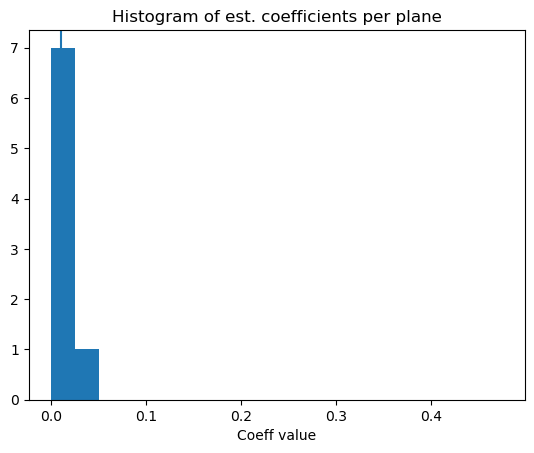

MovieWriter ffmpeg unavailable; using Pillow instead.


   Subtracting with estimated coefficient 0.010
         Subtracting plane 0 from 13
         Subtracting plane 1 from 14
         Subtracting plane 2 from 15
         Subtracting plane 3 from 16
         Subtracting plane 4 from 17
         Subtracting plane 5 from 18
         Subtracting plane 6 from 19
         Subtracting plane 7 from 20
   Using 2d registration
            Loaded mov and masks to GPU for rigid reg in 0.38 sec
            Allocating memory for shifted movie
            GPU RAM: 6 blocks allocated, 4.43 / 5.42 GB used
            Registering plane 0
            Shifting plane 0
            Registering plane 1
            Shifting plane 1
            Registering plane 2
            Shifting plane 2
            Registering plane 3
            Shifting plane 3
            Registering plane 4
            Shifting plane 4
            Registering plane 5
            Shifting plane 5
            Registering plane 6
            Shifting plane 6
            Registering plane

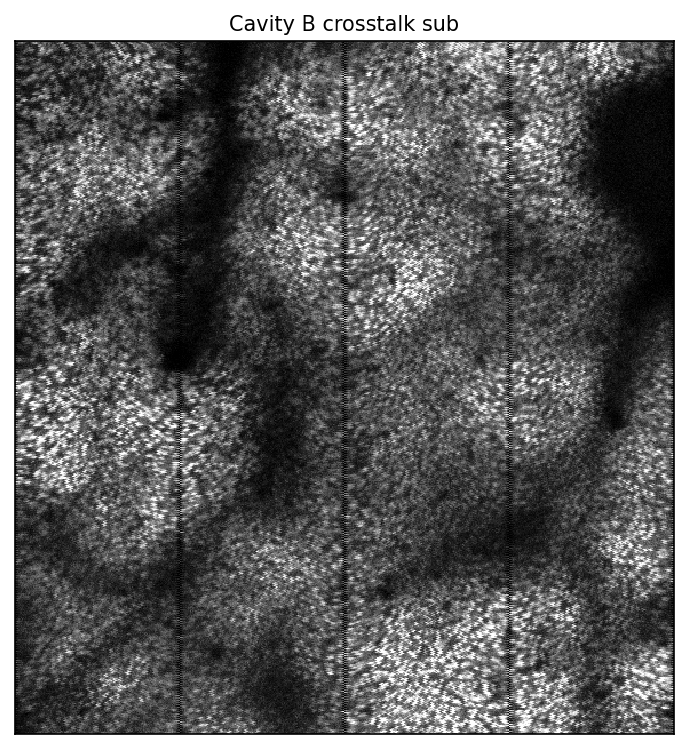

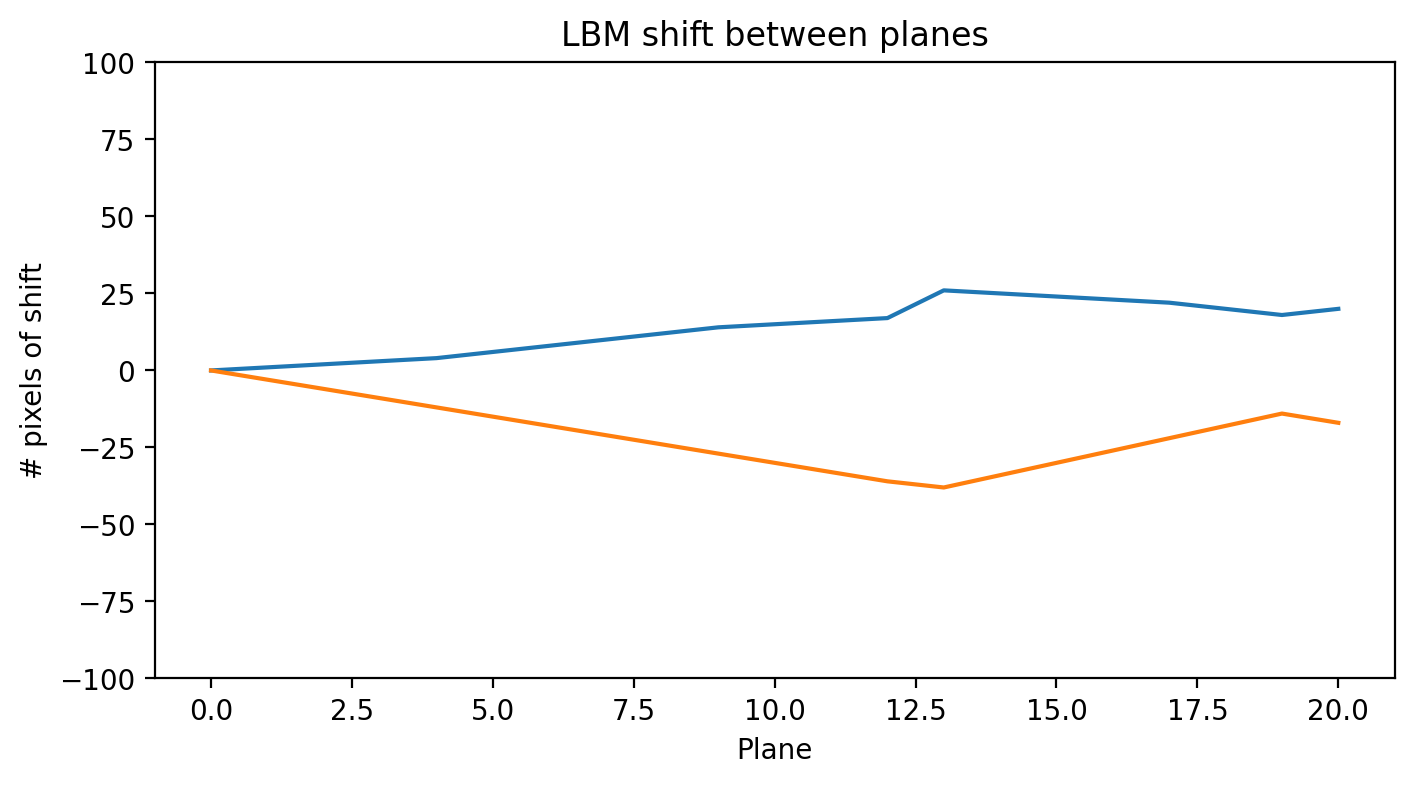

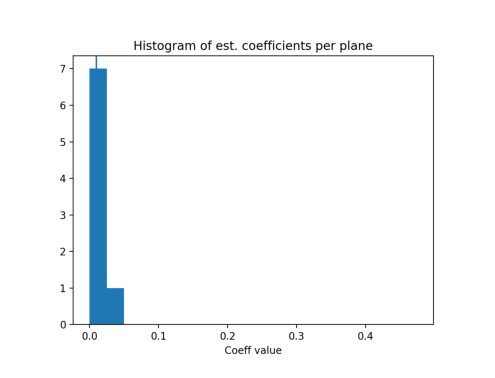

In [75]:
%%time
summary = job.run_init_pass()

In [76]:
summary = job.load_summary()

In [77]:
img = summary['ref_img_3d']

In [78]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [79]:
%%time
job.register()

      Found dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data
   Updated main params file
   Starting registration: 3D: False, GPU: True
   Overriding fuse shift value to 6
Will analyze 301 tifs in 301 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 158.015 GB, Virtual Available: 360.865 GB, Virtual Used: 142.331 GB, Swap Used: 015.684 GB
Loading Batch 0 of 300
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00001.tif
    Loaded file into shared memory in 7.09 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.85 sec
    Total time: 9.95 sec

   Loaded 1 files, total 1.37 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 159.347 GB, Virtual Available: 359.532 GB, Virtual Used: 143.664 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 160.715 GB, Virtual Available: 358.165 GB, Virtual Used: 145.031 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 154.338 GB, Virtual Available: 364.542 GB, Virtual Used: 138.654 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 154.338 GB, Virtual Available: 364.542 GB, Virtual Used: 138.654 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.07 sec
 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.44 sec
         Shifted batch in 1.53 sec
         Freeing all blocks
         Completed rigid registration in 3.33 sec
    Workers completed in 3.37 sec
    Total time: 12.06 sec
         Computed non-rigid shifts in 3.60 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.64 sec
         After GPU Batch:    Total Used: 161.548 GB, Virtual Available: 357.332 GB, Virtual Used: 145.864 GB, Swap Used: 015.684 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 161.549 GB, Virtual Available: 357.331 GB, Virtual Used: 145.865 GB, Swap Used: 015.684 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0000.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.38 sec
         After full batch saving:Total Used: 159.318 GB, Virtual Availa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.30 sec
    Total time: 16.84 sec

   Loaded 1 files, total 1.37 GB
   Batch 2 IO thread joined
         Memory after IO thread joinTotal Used: 159.357 GB, Virtual Available: 359.522 GB, Virtual Used: 143.673 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.350 GB, Virtual Available: 359.529 GB, Virtual Used: 143.666 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 157.987 GB, Virtual Available: 360.892 GB, Virtual Used: 142.303 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.987 GB, Virtual Available: 360.892 GB, Virtual Used: 142.303 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00004.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.33 sec
    Total time: 15.31 sec

   Loaded 1 files, total 1.37 GB
   Batch 3 IO thread joined
         Memory after IO thread joinTotal Used: 159.373 GB, Virtual Available: 359.507 GB, Virtual Used: 143.689 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.369 GB, Virtual Available: 359.510 GB, Virtual Used: 143.685 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 157.999 GB, Virtual Available: 360.880 GB, Virtual Used: 142.315 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.999 GB, Virtual Available: 360.880 GB, Virtual Used: 142.315 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00005.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.34 sec
    Total time: 15.18 sec

   Loaded 1 files, total 1.37 GB
   Batch 4 IO thread joined
         Memory after IO thread joinTotal Used: 159.377 GB, Virtual Available: 359.502 GB, Virtual Used: 143.694 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.372 GB, Virtual Available: 359.508 GB, Virtual Used: 143.688 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.009 GB, Virtual Available: 360.870 GB, Virtual Used: 142.325 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.009 GB, Virtual Available: 360.870 GB, Virtual Used: 142.325 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00006.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.28 sec
    Total time: 14.91 sec

   Loaded 1 files, total 1.37 GB
   Batch 5 IO thread joined
         Memory after IO thread joinTotal Used: 159.384 GB, Virtual Available: 359.496 GB, Virtual Used: 143.700 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.389 GB, Virtual Available: 359.490 GB, Virtual Used: 143.705 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.017 GB, Virtual Available: 360.863 GB, Virtual Used: 142.333 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.017 GB, Virtual Available: 360.863 GB, Virtual Used: 142.333 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00007.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.35 sec
    Total time: 16.17 sec

   Loaded 1 files, total 1.37 GB
   Batch 6 IO thread joined
         Memory after IO thread joinTotal Used: 159.410 GB, Virtual Available: 359.470 GB, Virtual Used: 143.726 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.411 GB, Virtual Available: 359.469 GB, Virtual Used: 143.727 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.038 GB, Virtual Available: 360.841 GB, Virtual Used: 142.354 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.038 GB, Virtual Available: 360.841 GB, Virtual Used: 142.354 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.27 sec
    Total time: 16.12 sec

   Loaded 1 files, total 1.37 GB
   Batch 7 IO thread joined
         Memory after IO thread joinTotal Used: 159.435 GB, Virtual Available: 359.445 GB, Virtual Used: 143.751 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.435 GB, Virtual Available: 359.444 GB, Virtual Used: 143.751 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.061 GB, Virtual Available: 360.819 GB, Virtual Used: 142.377 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.061 GB, Virtual Available: 360.819 GB, Virtual Used: 142.377 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00009.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.32 sec
    Total time: 15.27 sec

   Loaded 1 files, total 1.37 GB
   Batch 8 IO thread joined
         Memory after IO thread joinTotal Used: 159.429 GB, Virtual Available: 359.450 GB, Virtual Used: 143.745 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.421 GB, Virtual Available: 359.458 GB, Virtual Used: 143.737 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.059 GB, Virtual Available: 360.821 GB, Virtual Used: 142.375 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.059 GB, Virtual Available: 360.821 GB, Virtual Used: 142.375 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00010.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.39 sec
    Total time: 15.06 sec

   Loaded 1 files, total 1.37 GB
   Batch 9 IO thread joined
         Memory after IO thread joinTotal Used: 159.436 GB, Virtual Available: 359.444 GB, Virtual Used: 143.752 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.435 GB, Virtual Available: 359.444 GB, Virtual Used: 143.752 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.063 GB, Virtual Available: 360.816 GB, Virtual Used: 142.380 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.063 GB, Virtual Available: 360.816 GB, Virtual Used: 142.380 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00011.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.32 sec
    Total time: 15.53 sec

   Loaded 1 files, total 1.37 GB
   Batch 10 IO thread joined
         Memory after IO thread joinTotal Used: 159.456 GB, Virtual Available: 359.424 GB, Virtual Used: 143.772 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.449 GB, Virtual Available: 359.431 GB, Virtual Used: 143.765 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.084 GB, Virtual Available: 360.795 GB, Virtual Used: 142.401 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.084 GB, Virtual Available: 360.795 GB, Virtual Used: 142.401 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00012.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.29 sec
    Total time: 15.44 sec

   Loaded 1 files, total 1.37 GB
   Batch 11 IO thread joined
         Memory after IO thread joinTotal Used: 159.451 GB, Virtual Available: 359.428 GB, Virtual Used: 143.767 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.444 GB, Virtual Available: 359.435 GB, Virtual Used: 143.761 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.082 GB, Virtual Available: 360.797 GB, Virtual Used: 142.398 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.082 GB, Virtual Available: 360.797 GB, Virtual Used: 142.398 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00013.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.34 sec
    Total time: 16.22 sec

   Loaded 1 files, total 1.37 GB
   Batch 12 IO thread joined
         Memory after IO thread joinTotal Used: 159.452 GB, Virtual Available: 359.428 GB, Virtual Used: 143.768 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.448 GB, Virtual Available: 359.431 GB, Virtual Used: 143.765 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.078 GB, Virtual Available: 360.802 GB, Virtual Used: 142.394 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.078 GB, Virtual Available: 360.802 GB, Virtual Used: 142.394 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.44 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.790 GB, Virtual Available: 356.089 GB, Virtual Used: 147.106 GB, Swap Used: 015.684 GB
         Memory at batch 13. Total Used: 162.796 GB, Virtual Available: 356.084 GB, Virtual Used: 147.112 GB, Swap Used: 015.684 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 13 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.20 sec
    Total time: 13.06 sec

   Loaded 1 files, total 1.37 GB
   Batch 13 IO thread joined
         Memory after IO thread joinTotal Used: 159.451 GB, Virtual Available: 359.428 GB, Virtual Used: 143.767 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.449 GB, Virtual Available: 359.431 GB, Virtual Used: 143.765 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.083 GB, Virtual Available: 360.797 GB, Virtual Used: 142.399 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.083 GB, Virtual Available: 360.797 GB, Virtual Used: 142.399 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00015.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.30 sec
    Total time: 14.89 sec

   Loaded 1 files, total 1.37 GB
   Batch 14 IO thread joined
         Memory after IO thread joinTotal Used: 159.509 GB, Virtual Available: 359.371 GB, Virtual Used: 143.825 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.504 GB, Virtual Available: 359.376 GB, Virtual Used: 143.820 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.139 GB, Virtual Available: 360.740 GB, Virtual Used: 142.456 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.139 GB, Virtual Available: 360.740 GB, Virtual Used: 142.456 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00016.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.14 sec
    Total time: 14.61 sec

   Loaded 1 files, total 1.37 GB
   Batch 15 IO thread joined
         Memory after IO thread joinTotal Used: 159.518 GB, Virtual Available: 359.361 GB, Virtual Used: 143.834 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.519 GB, Virtual Available: 359.361 GB, Virtual Used: 143.835 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.144 GB, Virtual Available: 360.735 GB, Virtual Used: 142.461 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.144 GB, Virtual Available: 360.735 GB, Virtual Used: 142.461 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00017.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.47 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.853 GB, Virtual Available: 356.026 GB, Virtual Used: 147.169 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 16. Total Used: 163.051 GB, Virtual Available: 355.829 GB, Virtual Used: 147.367 GB, Swap Used: 015.684 GB
Loading Batch 16 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 16. Total Used: 163.051 GB, Virtual Available: 355.829 GB, Virtual Used: 147.367 GB, Swap Used: 015.684 GB
Loading Batch 16 of 300
    Workers completed in 3.23 sec
    Total time: 13.16 sec

   Loaded 1 files, total 1.37 GB
   Batch 16 IO thread joined
         Memory after IO thread joinTotal Used: 159.512 GB, Virtual Available: 359.367 GB, Virtual Used: 143.828 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.510 GB, Virtual Available: 359.369 GB, Virtual Used: 143.826 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.138 GB, Virtual Available: 360.742 GB, Virtual Used: 142.454 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.138 GB, Virtual Available: 360.742 GB, Virtual Used: 142.454 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Lo

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.23 sec
    Total time: 14.87 sec

   Loaded 1 files, total 1.37 GB
   Batch 17 IO thread joined
         Memory after IO thread joinTotal Used: 159.517 GB, Virtual Available: 359.363 GB, Virtual Used: 143.833 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.520 GB, Virtual Available: 359.359 GB, Virtual Used: 143.836 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.156 GB, Virtual Available: 360.723 GB, Virtual Used: 142.472 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.156 GB, Virtual Available: 360.723 GB, Virtual Used: 142.472 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00019.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.58 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.843 GB, Virtual Available: 355.036 GB, Virtual Used: 148.159 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 18. Total Used: 164.040 GB, Virtual Available: 354.839 GB, Virtual Used: 148.357 GB, Swap Used: 015.684 GB
Loading Batch 18 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 2.95 sec
    Total time: 12.28 sec

   Loaded 1 files, total 1.37 GB
   Batch 18 IO thread joined
         Memory after IO thread joinTotal Used: 159.533 GB, Virtual Available: 359.347 GB, Virtual Used: 143.849 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.536 GB, Virtual Available: 359.344 GB, Virtual Used: 143.852 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.163 GB, Virtual Available: 360.716 GB, Virtual Used: 142.480 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.163 GB, Virtual Available: 360.716 GB, Virtual Used: 142.480 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00020.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.42 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.272 GB, Virtual Available: 355.607 GB, Virtual Used: 147.589 GB, Swap Used: 015.684 GB
         Memory at batch 19. Total Used: 163.275 GB, Virtual Available: 355.605 GB, Virtual Used: 147.591 GB, Swap Used: 015.684 GB
Loading Batch 19 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.272 GB, Virtual Available: 355.607 GB, Virtual Used: 147.589 GB, Swap Used: 015.684 GB
    Workers completed in 2.83 sec
    Total time: 12.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 19 IO thread joined
         Memory after IO thread joinTotal Used: 159.520 GB, Virtual Available: 359.359 GB, Virtual Used: 143.837 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.519 GB, Virtual Available: 359.360 GB, Virtual Used: 143.835 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.153 GB, Virtual Available: 360.726 GB, Virtual Used: 142.469 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00021.tif
         After IO thread launch:Total Used: 158.153 GB, Virtual Available: 360.726 GB, Virtual Used: 142.469 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.84 sec
    Total time: 14.51 sec

   Loaded 1 files, total 1.37 GB
   Batch 20 IO thread joined
         Memory after IO thread joinTotal Used: 159.542 GB, Virtual Available: 359.337 GB, Virtual Used: 143.858 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.542 GB, Virtual Available: 359.337 GB, Virtual Used: 143.858 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.179 GB, Virtual Available: 360.700 GB, Virtual Used: 142.496 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.179 GB, Virtual Available: 360.700 GB, Virtual Used: 142.496 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00022.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 0.97 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 165.701 GB, Virtual Available: 353.178 GB, Virtual Used: 150.018 GB, Swap Used: 015.684 GB
      Concatenating movie
         Concat in 0.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After all GPU Batches:Total Used: 166.152 GB, Virtual Available: 352.727 GB, Virtual Used: 150.469 GB, Swap Used: 015.684 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0020.npy


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 2.98 sec
    Total time: 12.13 sec
         Saved in 1.71 sec
         After full batch saving:Total Used: 161.453 GB, Virtual Available: 357.427 GB, Virtual Used: 145.769 GB, Swap Used: 015.684 GB
         Memory at batch 21. Total Used: 161.453 GB, Virtual Available: 357.426 GB, Virtual Used: 145.770 GB, Swap Used: 015.684 GB
Loading Batch 21 of 300

   Loaded 1 files, total 1.37 GB
   Batch 21 IO thread joined
         Memory after IO thread joinTotal Used: 159.547 GB, Virtual Available: 359.333 GB, Virtual Used: 143.863 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.550 GB, Virtual Available: 359.330 GB, Virtual Used: 143.866 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.180 GB, Virtual Available: 360.700 GB, Virtual Used: 142.496 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.180 GB, Virtual Available: 360.700 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.92 sec
    Total time: 13.75 sec

   Loaded 1 files, total 1.37 GB
   Batch 22 IO thread joined
         Memory after IO thread joinTotal Used: 159.561 GB, Virtual Available: 359.318 GB, Virtual Used: 143.877 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.556 GB, Virtual Available: 359.323 GB, Virtual Used: 143.873 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.194 GB, Virtual Available: 360.686 GB, Virtual Used: 142.510 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.194 GB, Virtual Available: 360.686 GB, Virtual Used: 142.510 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00024.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.30 sec
         After GPU Batch:    Total Used: 171.411 GB, Virtual Available: 347.469 GB, Virtual Used: 155.727 GB, Swap Used: 015.684 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.417 GB, Virtual Available: 347.462 GB, Virtual Used: 155.734 GB, Swap Used: 015.684 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0022.npy
    Workers completed in 3.12 sec
    Total time: 12.15 sec

         Saved in 1.40 sec
         After full batch saving:Total Used: 159.766 GB, Virtual Available: 359.113 GB, Virtual Used: 144.083 GB, Swap Used: 015.684 GB
         Memory at batch 23. Total Used: 159.766 GB, Virtual Available: 359.113 GB, Virtual Used: 144.083 GB, Swap Used: 015.684 GB
Loading Batch 23 of 300
   Loaded 1 files, total 1.37 GB
   Batch 23 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.41 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.697 GB, Virtual Available: 355.182 GB, Virtual Used: 148.013 GB, Swap Used: 015.684 GB
         Memory at batch 24. Total Used: 163.891 GB, Virtual Available: 354.989 GB, Virtual Used: 148.207 GB, Swap Used: 015.684 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 24 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 24 of 300
    Workers completed in 2.88 sec
    Total time: 12.28 sec

   Loaded 1 files, total 1.37 GB
   Batch 24 IO thread joined
         Memory after IO thread joinTotal Used: 159.579 GB, Virtual Available: 359.301 GB, Virtual Used: 143.895 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.576 GB, Virtual Available: 359.303 GB, Virtual Used: 143.892 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.213 GB, Virtual Available: 360.666 GB, Virtual Used: 142.530 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.213 GB, Virtual Available: 360.666 GB, Virtual Used: 142.530 GB, Swap Used: 015.684 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00026.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.46 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.116 GB, Virtual Available: 355.763 GB, Virtual Used: 147.432 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 25. Total Used: 163.312 GB, Virtual Available: 355.568 GB, Virtual Used: 147.628 GB, Swap Used: 015.684 GB
Loading Batch 25 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 25. Total Used: 163.312 GB, Virtual Available: 355.568 GB, Virtual Used: 147.628 GB, Swap Used: 015.684 GB
Loading Batch 25 of 300
         After full batch saving:Total Used: 163.116 GB, Virtual Available: 355.763 GB, Virtual Used: 147.432 GB, Swap Used: 015.684 GB
    Workers completed in 2.69 sec
    Total time: 12.54 sec

   Loaded 1 files, total 1.37 GB
   Batch 25 IO thread joined
         Memory after IO thread joinTotal Used: 159.584 GB, Virtual Available: 359.295 GB, Virtual Used: 143.901 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.582 GB, Virtual Available: 359.297 GB, Virtual Used: 143.899 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.210 GB, Virtual Available: 360.669 GB, Virtual Used: 142.526 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.210 GB, Virtual Available: 360.669 GB, Virtual Used: 142.526 GB, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.36 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.714 GB, Virtual Available: 355.165 GB, Virtual Used: 148.031 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 26. Total Used: 163.910 GB, Virtual Available: 354.969 GB, Virtual Used: 148.227 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 26 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 26 of 300
    Workers completed in 2.71 sec
    Total time: 12.01 sec

   Loaded 1 files, total 1.37 GB
   Batch 26 IO thread joined
         Memory after IO thread joinTotal Used: 159.615 GB, Virtual Available: 359.264 GB, Virtual Used: 143.931 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.610 GB, Virtual Available: 359.269 GB, Virtual Used: 143.926 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.248 GB, Virtual Available: 360.632 GB, Virtual Used: 142.564 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.248 GB, Virtual Available: 360.632 GB, Virtual Used: 142.564 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00028.tif
         Registered batch in 0.01 sec
         S

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.29 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.772 GB, Virtual Available: 356.107 GB, Virtual Used: 147.089 GB, Swap Used: 015.684 GB
         Memory at batch 27. Total Used: 162.775 GB, Virtual Available: 356.105 GB, Virtual Used: 147.091 GB, Swap Used: 015.684 GB
Loading Batch 27 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.68 sec
    Total time: 12.63 sec

   Loaded 1 files, total 1.37 GB
   Batch 27 IO thread joined
         Memory after IO thread joinTotal Used: 159.627 GB, Virtual Available: 359.252 GB, Virtual Used: 143.944 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.621 GB, Virtual Available: 359.258 GB, Virtual Used: 143.937 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.257 GB, Virtual Available: 360.622 GB, Virtual Used: 142.573 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.257 GB, Virtual Available: 360.622 GB, Virtual Used: 142.573 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00029.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.40 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.338 GB, Virtual Available: 355.541 GB, Virtual Used: 147.655 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 28. Total Used: 163.345 GB, Virtual Available: 355.534 GB, Virtual Used: 147.661 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 28 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 2.72 sec
    Total time: 12.45 sec

   Loaded 1 files, total 1.37 GB
   Batch 28 IO thread joined
         Memory after IO thread joinTotal Used: 159.637 GB, Virtual Available: 359.243 GB, Virtual Used: 143.953 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.626 GB, Virtual Available: 359.254 GB, Virtual Used: 143.942 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.261 GB, Virtual Available: 360.618 GB, Virtual Used: 142.578 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.261 GB, Virtual Available: 360.618 GB, Virtual Used: 142.578 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00030.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.40 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.365 GB, Virtual Available: 355.514 GB, Virtual Used: 147.681 GB, Swap Used: 015.684 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 29. Total Used: 163.565 GB, Virtual Available: 355.314 GB, Virtual Used: 147.881 GB, Swap Used: 015.684 GB
Loading Batch 29 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 2.68 sec
    Total time: 12.27 sec

   Loaded 1 files, total 1.37 GB
   Batch 29 IO thread joined
         Memory after IO thread joinTotal Used: 159.634 GB, Virtual Available: 359.245 GB, Virtual Used: 143.951 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.634 GB, Virtual Available: 359.246 GB, Virtual Used: 143.950 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.263 GB, Virtual Available: 360.616 GB, Virtual Used: 142.580 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.263 GB, Virtual Available: 360.616 GB, Virtual Used: 142.580 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00031.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.04 sec
         After GPU Batch:    Total Used: 172.346 GB, Virtual Available: 346.534 GB, Virtual Used: 156.662 GB, Swap Used: 015.684 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.355 GB, Virtual Available: 346.524 GB, Virtual Used: 156.672 GB, Swap Used: 015.684 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0029.npy
    Workers completed in 2.93 sec
    Total time: 11.94 sec
         Saved in 1.42 sec
         After full batch saving:Total Used: 162.794 GB, Virtual Available: 356.085 GB, Virtual Used: 147.111 GB, Swap Used: 015.684 GB
         Memory at batch 30. Total Used: 162.795 GB, Virtual Available: 356.085 GB, Virtual Used: 147.111 GB, Swap Used: 015.684 GB
Loading Batch 30 of 300

   Loaded 1 files, total 1.37 GB
   Batch 30 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.81 sec
    Total time: 14.08 sec

   Loaded 1 files, total 1.37 GB
   Batch 31 IO thread joined
         Memory after IO thread joinTotal Used: 159.674 GB, Virtual Available: 359.205 GB, Virtual Used: 143.991 GB, Swap Used: 015.684 GB
         Memory after movie copied from threadTotal Used: 159.674 GB, Virtual Available: 359.205 GB, Virtual Used: 143.990 GB, Swap Used: 015.684 GB
         Memory after thread memory clearedTotal Used: 158.298 GB, Virtual Available: 360.581 GB, Virtual Used: 142.614 GB, Swap Used: 015.684 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.298 GB, Virtual Available: 360.581 GB, Virtual Used: 142.614 GB, Swap Used: 015.684 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 7.20 sec
    Total time: 17.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 32 IO thread joined
         Memory after IO thread joinTotal Used: 159.472 GB, Virtual Available: 359.410 GB, Virtual Used: 143.786 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.471 GB, Virtual Available: 359.410 GB, Virtual Used: 143.785 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.102 GB, Virtual Available: 360.779 GB, Virtual Used: 142.417 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.102 GB, Virtual Available: 360.779 GB, Virtual Used: 142.417 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00034.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.39 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.407 GB, Virtual Available: 355.474 GB, Virtual Used: 147.722 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 33. Total Used: 163.604 GB, Virtual Available: 355.277 GB, Virtual Used: 147.918 GB, Swap Used: 015.686 GB
Loading Batch 33 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.32 sec
    Total time: 12.74 sec

   Loaded 1 files, total 1.37 GB
   Batch 33 IO thread joined
         Memory after IO thread joinTotal Used: 160.243 GB, Virtual Available: 358.638 GB, Virtual Used: 144.557 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.249 GB, Virtual Available: 358.632 GB, Virtual Used: 144.564 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.875 GB, Virtual Available: 360.006 GB, Virtual Used: 143.190 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.875 GB, Virtual Available: 360.006 GB, Virtual Used: 143.190 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00035.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.40 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.348 GB, Virtual Available: 354.533 GB, Virtual Used: 148.662 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 34. Total Used: 164.545 GB, Virtual Available: 354.336 GB, Virtual Used: 148.860 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 34 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 34 of 300
    Workers completed in 3.43 sec
    Total time: 12.93 sec

   Loaded 1 files, total 1.37 GB
   Batch 34 IO thread joined
         Memory after IO thread joinTotal Used: 162.613 GB, Virtual Available: 356.268 GB, Virtual Used: 146.927 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.608 GB, Virtual Available: 356.273 GB, Virtual Used: 146.923 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.241 GB, Virtual Available: 357.640 GB, Virtual Used: 145.556 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.241 GB, Virtual Available: 357.640 GB, Virtual Used: 145.556 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00036.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         S

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.46 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.366 GB, Virtual Available: 352.515 GB, Virtual Used: 150.681 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 35. Total Used: 166.565 GB, Virtual Available: 352.317 GB, Virtual Used: 150.879 GB, Swap Used: 015.686 GB
Loading Batch 35 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.20 sec
    Total time: 12.79 sec

   Loaded 1 files, total 1.37 GB
   Batch 35 IO thread joined
         Memory after IO thread joinTotal Used: 159.370 GB, Virtual Available: 359.511 GB, Virtual Used: 143.685 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.362 GB, Virtual Available: 359.519 GB, Virtual Used: 143.677 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.996 GB, Virtual Available: 360.885 GB, Virtual Used: 142.311 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.996 GB, Virtual Available: 360.885 GB, Virtual Used: 142.311 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00037.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.36 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.151 GB, Virtual Available: 356.730 GB, Virtual Used: 146.466 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 36. Total Used: 162.347 GB, Virtual Available: 356.534 GB, Virtual Used: 146.661 GB, Swap Used: 015.686 GB
Loading Batch 36 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Memory at batch 36. Total Used: 162.347 GB, Virtual Available: 356.534 GB, Virtual Used: 146.661 GB, Swap Used: 015.686 GB
    Workers completed in 3.25 sec
    Total time: 13.58 sec

   Loaded 1 files, total 1.37 GB
   Batch 36 IO thread joined
         Memory after IO thread joinTotal Used: 162.619 GB, Virtual Available: 356.262 GB, Virtual Used: 146.933 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.621 GB, Virtual Available: 356.260 GB, Virtual Used: 146.936 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.249 GB, Virtual Available: 357.633 GB, Virtual Used: 145.563 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.249 GB, Virtual Available: 357.633 GB, Virtual Used: 145.563 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00038.tif

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.34 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.562 GB, Virtual Available: 353.319 GB, Virtual Used: 149.876 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 37. Total Used: 165.566 GB, Virtual Available: 353.315 GB, Virtual Used: 149.881 GB, Swap Used: 015.686 GB
Loading Batch 37 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         After full batch saving:Total Used: 165.562 GB, Virtual Available: 353.319 GB, Virtual Used: 149.876 GB, Swap Used: 015.686 GB
    Workers completed in 3.44 sec
    Total time: 13.54 sec

   Loaded 1 files, total 1.37 GB
   Batch 37 IO thread joined
         Memory after IO thread joinTotal Used: 159.451 GB, Virtual Available: 359.430 GB, Virtual Used: 143.766 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.443 GB, Virtual Available: 359.438 GB, Virtual Used: 143.757 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.077 GB, Virtual Available: 360.805 GB, Virtual Used: 142.391 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.077 GB, Virtual Available: 360.805 GB, Virtual Used: 142.391 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00039.tif
      Loaded batch of size (21, 100, 606, 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.60 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.766 GB, Virtual Available: 355.115 GB, Virtual Used: 148.080 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 38. Total Used: 163.964 GB, Virtual Available: 354.917 GB, Virtual Used: 148.278 GB, Swap Used: 015.686 GB
Loading Batch 38 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.37 sec
    Total time: 12.82 sec

   Loaded 1 files, total 1.37 GB
   Batch 38 IO thread joined
         Memory after IO thread joinTotal Used: 162.656 GB, Virtual Available: 356.226 GB, Virtual Used: 146.970 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.662 GB, Virtual Available: 356.219 GB, Virtual Used: 146.976 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.301 GB, Virtual Available: 357.580 GB, Virtual Used: 145.615 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.293 GB, Virtual Available: 357.588 GB, Virtual Used: 145.607 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00040.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.50 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.197 GB, Virtual Available: 352.684 GB, Virtual Used: 150.511 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 39. Total Used: 166.394 GB, Virtual Available: 352.487 GB, Virtual Used: 150.708 GB, Swap Used: 015.686 GB
Loading Batch 39 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.31 sec
    Total time: 13.24 sec

   Loaded 1 files, total 1.37 GB
   Batch 39 IO thread joined
         Memory after IO thread joinTotal Used: 159.383 GB, Virtual Available: 359.498 GB, Virtual Used: 143.697 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.378 GB, Virtual Available: 359.503 GB, Virtual Used: 143.692 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.006 GB, Virtual Available: 360.875 GB, Virtual Used: 142.321 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.006 GB, Virtual Available: 360.875 GB, Virtual Used: 142.321 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00041.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.47 sec
    Total time: 14.26 sec

   Loaded 1 files, total 1.37 GB
   Batch 40 IO thread joined
         Memory after IO thread joinTotal Used: 162.663 GB, Virtual Available: 356.218 GB, Virtual Used: 146.977 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.668 GB, Virtual Available: 356.213 GB, Virtual Used: 146.983 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.298 GB, Virtual Available: 357.583 GB, Virtual Used: 145.613 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.298 GB, Virtual Available: 357.583 GB, Virtual Used: 145.613 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00042.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.47 sec
    Total time: 14.32 sec

   Loaded 1 files, total 1.37 GB
   Batch 41 IO thread joined
         Memory after IO thread joinTotal Used: 159.439 GB, Virtual Available: 359.442 GB, Virtual Used: 143.754 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.439 GB, Virtual Available: 359.442 GB, Virtual Used: 143.753 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.071 GB, Virtual Available: 360.810 GB, Virtual Used: 142.385 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.071 GB, Virtual Available: 360.810 GB, Virtual Used: 142.385 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00043.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.55 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.365 GB, Virtual Available: 355.516 GB, Virtual Used: 147.680 GB, Swap Used: 015.686 GB
         Memory at batch 42. Total Used: 163.563 GB, Virtual Available: 355.318 GB, Virtual Used: 147.877 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 42 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.53 sec
    Total time: 13.10 sec

   Loaded 1 files, total 1.37 GB
   Batch 42 IO thread joined
         Memory after IO thread joinTotal Used: 162.696 GB, Virtual Available: 356.185 GB, Virtual Used: 147.010 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.594 GB, Virtual Available: 356.287 GB, Virtual Used: 146.908 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.232 GB, Virtual Available: 357.649 GB, Virtual Used: 145.547 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.232 GB, Virtual Available: 357.649 GB, Virtual Used: 145.547 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00044.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.56 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.550 GB, Virtual Available: 352.331 GB, Virtual Used: 150.864 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 43. Total Used: 166.744 GB, Virtual Available: 352.137 GB, Virtual Used: 151.058 GB, Swap Used: 015.686 GB
Loading Batch 43 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.54 sec
    Total time: 13.18 sec

   Loaded 1 files, total 1.37 GB
   Batch 43 IO thread joined
         Memory after IO thread joinTotal Used: 159.418 GB, Virtual Available: 359.464 GB, Virtual Used: 143.732 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.353 GB, Virtual Available: 359.528 GB, Virtual Used: 143.668 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.987 GB, Virtual Available: 360.894 GB, Virtual Used: 142.302 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.988 GB, Virtual Available: 360.893 GB, Virtual Used: 142.303 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00045.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.18 sec
    Workers completed in 3.97 sec
    Total time: 12.97 sec
         After GPU Batch:    Total Used: 173.100 GB, Virtual Available: 345.782 GB, Virtual Used: 157.414 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.100 GB, Virtual Available: 345.781 GB, Virtual Used: 157.414 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0043.npy
         Saved in 1.78 sec

         After full batch saving:Total Used: 162.679 GB, Virtual Available: 356.202 GB, Virtual Used: 146.993 GB, Swap Used: 015.686 GB
         Memory at batch 44. Total Used: 162.679 GB, Virtual Available: 356.202 GB, Virtual Used: 146.993 GB, Swap Used: 015.686 GB
Loading Batch 44 of 300
   Loaded 1 files, total 1.37 GB
   Batch 44 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.50 sec
    Total time: 15.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 45 IO thread joined
         Memory after IO thread joinTotal Used: 159.444 GB, Virtual Available: 359.437 GB, Virtual Used: 143.759 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.444 GB, Virtual Available: 359.437 GB, Virtual Used: 143.759 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.078 GB, Virtual Available: 360.803 GB, Virtual Used: 142.392 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.078 GB, Virtual Available: 360.803 GB, Virtual Used: 142.392 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00047.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.39 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.782 GB, Virtual Available: 356.100 GB, Virtual Used: 147.096 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 46. Total Used: 162.976 GB, Virtual Available: 355.905 GB, Virtual Used: 147.291 GB, Swap Used: 015.686 GB
Loading Batch 46 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 46. Total Used: 162.976 GB, Virtual Available: 355.905 GB, Virtual Used: 147.291 GB, Swap Used: 015.686 GB
Loading Batch 46 of 300
    Workers completed in 3.40 sec
    Total time: 13.29 sec

   Loaded 1 files, total 1.37 GB
   Batch 46 IO thread joined
         Memory after IO thread joinTotal Used: 162.700 GB, Virtual Available: 356.182 GB, Virtual Used: 147.014 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.694 GB, Virtual Available: 356.188 GB, Virtual Used: 147.008 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.331 GB, Virtual Available: 357.550 GB, Virtual Used: 145.645 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.331 GB, Virtual Available: 357.550 GB, Virtual Used: 145.645 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Lo

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.52 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.638 GB, Virtual Available: 352.243 GB, Virtual Used: 150.952 GB, Swap Used: 015.686 GB
         Memory at batch 47. Total Used: 166.835 GB, Virtual Available: 352.046 GB, Virtual Used: 151.149 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 47 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.62 sec
    Total time: 13.30 sec

   Loaded 1 files, total 1.37 GB
   Batch 47 IO thread joined
         Memory after IO thread joinTotal Used: 159.504 GB, Virtual Available: 359.377 GB, Virtual Used: 143.819 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.397 GB, Virtual Available: 359.484 GB, Virtual Used: 143.711 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.011 GB, Virtual Available: 360.871 GB, Virtual Used: 142.325 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.011 GB, Virtual Available: 360.871 GB, Virtual Used: 142.325 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00049.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.42 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.140 GB, Virtual Available: 355.741 GB, Virtual Used: 147.454 GB, Swap Used: 015.686 GB
         Memory at batch 48. Total Used: 163.335 GB, Virtual Available: 355.547 GB, Virtual Used: 147.649 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 48 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.63 sec
    Total time: 13.24 sec

   Loaded 1 files, total 1.37 GB
   Batch 48 IO thread joined
         Memory after IO thread joinTotal Used: 162.611 GB, Virtual Available: 356.270 GB, Virtual Used: 146.926 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.549 GB, Virtual Available: 356.332 GB, Virtual Used: 146.864 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.173 GB, Virtual Available: 357.708 GB, Virtual Used: 145.487 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.174 GB, Virtual Available: 357.707 GB, Virtual Used: 145.488 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00050.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.90 sec
         After GPU Batch:    Total Used: 175.177 GB, Virtual Available: 343.704 GB, Virtual Used: 159.492 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 175.179 GB, Virtual Available: 343.702 GB, Virtual Used: 159.493 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0048.npy
    Workers completed in 3.98 sec
    Total time: 13.18 sec
         Saved in 1.85 sec
         After full batch saving:Total Used: 162.651 GB, Virtual Available: 356.231 GB, Virtual Used: 146.965 GB, Swap Used: 015.686 GB
         Memory at batch 49. Total Used: 162.651 GB, Virtual Available: 356.230 GB, Virtual Used: 146.966 GB, Swap Used: 015.686 GB
Loading Batch 49 of 300

   Loaded 1 files, total 1.37 GB
   Batch 49 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 14.63 sec

   Loaded 1 files, total 1.37 GB
   Batch 50 IO thread joined
         Memory after IO thread joinTotal Used: 162.633 GB, Virtual Available: 356.248 GB, Virtual Used: 146.947 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.629 GB, Virtual Available: 356.252 GB, Virtual Used: 146.943 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.263 GB, Virtual Available: 357.618 GB, Virtual Used: 145.577 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.263 GB, Virtual Available: 357.618 GB, Virtual Used: 145.577 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00052.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.36 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.769 GB, Virtual Available: 353.112 GB, Virtual Used: 150.084 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 51. Total Used: 165.967 GB, Virtual Available: 352.914 GB, Virtual Used: 150.281 GB, Swap Used: 015.686 GB
Loading Batch 51 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 13.76 sec

   Loaded 1 files, total 1.37 GB
   Batch 51 IO thread joined
         Memory after IO thread joinTotal Used: 159.530 GB, Virtual Available: 359.351 GB, Virtual Used: 143.845 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.528 GB, Virtual Available: 359.353 GB, Virtual Used: 143.843 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.158 GB, Virtual Available: 360.723 GB, Virtual Used: 142.473 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.158 GB, Virtual Available: 360.723 GB, Virtual Used: 142.473 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00053.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.57 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.427 GB, Virtual Available: 355.454 GB, Virtual Used: 147.741 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 52. Total Used: 163.431 GB, Virtual Available: 355.451 GB, Virtual Used: 147.745 GB, Swap Used: 015.686 GB
Loading Batch 52 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.70 sec
    Total time: 13.28 sec

   Loaded 1 files, total 1.37 GB
   Batch 52 IO thread joined
         Memory after IO thread joinTotal Used: 162.487 GB, Virtual Available: 356.395 GB, Virtual Used: 146.801 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.484 GB, Virtual Available: 356.397 GB, Virtual Used: 146.799 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.118 GB, Virtual Available: 357.763 GB, Virtual Used: 145.433 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.120 GB, Virtual Available: 357.762 GB, Virtual Used: 145.434 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00054.tif
         Registered batch in 0.03 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.42 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.234 GB, Virtual Available: 352.647 GB, Virtual Used: 150.549 GB, Swap Used: 015.686 GB
         Memory at batch 53. Total Used: 166.237 GB, Virtual Available: 352.644 GB, Virtual Used: 150.551 GB, Swap Used: 015.686 GB
Loading Batch 53 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.27 sec
    Total time: 12.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 53 IO thread joined
         Memory after IO thread joinTotal Used: 162.592 GB, Virtual Available: 356.289 GB, Virtual Used: 146.907 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.591 GB, Virtual Available: 356.290 GB, Virtual Used: 146.906 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.218 GB, Virtual Available: 357.663 GB, Virtual Used: 145.532 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.218 GB, Virtual Available: 357.663 GB, Virtual Used: 145.532 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/1/2024-08-26_1_CR029_2P_00001_00055.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.31 sec
         Shifted batch in 1.36 sec
         Freeing all blocks
    Workers completed in 2.67 sec
    Total time: 3.86 sec
         Completed rigid registration in 2.98 sec
         Computed non-rigid shifts in 3.21 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec

   Loaded 1 files, total 0.23 GB
         Non rigid transformed (on CPU) in 0.53 sec
         After GPU Batch:    Total Used: 162.018 GB, Virtual Available: 356.864 GB, Virtual Used: 146.332 GB, Swap Used: 015.686 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.07 sec
         Freeing all blocks
         Completed rigid registration in 0.24 sec
         Computed non-rigid shifts in 0.44 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.49 sec
         After GPU Batch:    Total Used: 162.313 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.59 sec
    Total time: 11.20 sec

   Loaded 1 files, total 1.37 GB
   Batch 55 IO thread joined
         Memory after IO thread joinTotal Used: 155.156 GB, Virtual Available: 363.725 GB, Virtual Used: 139.471 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 156.526 GB, Virtual Available: 362.355 GB, Virtual Used: 140.840 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 155.157 GB, Virtual Available: 363.725 GB, Virtual Used: 139.471 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 155.157 GB, Virtual Available: 363.725 GB, Virtual Used: 139.471 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.59 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.083 GB, Virtual Available: 355.798 GB, Virtual Used: 147.397 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 56. Total Used: 163.272 GB, Virtual Available: 355.609 GB, Virtual Used: 147.586 GB, Swap Used: 015.686 GB
Loading Batch 56 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.45 sec
    Total time: 13.10 sec

   Loaded 1 files, total 1.37 GB
   Batch 56 IO thread joined
         Memory after IO thread joinTotal Used: 159.403 GB, Virtual Available: 359.478 GB, Virtual Used: 143.717 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.405 GB, Virtual Available: 359.476 GB, Virtual Used: 143.720 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.039 GB, Virtual Available: 360.843 GB, Virtual Used: 142.353 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.039 GB, Virtual Available: 360.843 GB, Virtual Used: 142.353 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00003.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.22 sec
         After GPU Batch:    Total Used: 176.164 GB, Virtual Available: 342.718 GB, Virtual Used: 160.478 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 176.174 GB, Virtual Available: 342.707 GB, Virtual Used: 160.489 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0056.npy
    Workers completed in 4.07 sec
    Total time: 13.23 sec
         Saved in 1.60 sec
         After full batch saving:Total Used: 163.519 GB, Virtual Available: 355.362 GB, Virtual Used: 147.834 GB, Swap Used: 015.686 GB
         Memory at batch 57. Total Used: 163.520 GB, Virtual Available: 355.362 GB, Virtual Used: 147.834 GB, Swap Used: 015.686 GB
Loading Batch 57 of 300

   Loaded 1 files, total 1.37 GB
   Batch 57 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.50 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.05 sec
    Total time: 12.66 sec
         Non rigid transformed (on CPU) in 0.98 sec
         After GPU Batch:    Total Used: 171.521 GB, Virtual Available: 347.360 GB, Virtual Used: 155.835 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.521 GB, Virtual Available: 347.360 GB, Virtual Used: 155.835 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0057.npy

         Saved in 1.62 sec
         After full batch saving:Total Used: 162.384 GB, Virtual Available: 356.497 GB, Virtual Used: 146.698 GB, Swap Used: 015.686 GB
         Memory at batch 58. Total Used: 162.384 GB, Virtual Available: 356.497 GB, Virtual Used: 146.699 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.51 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.12 sec
    Total time: 12.54 sec
         Non rigid transformed (on CPU) in 1.25 sec
         After GPU Batch:    Total Used: 167.609 GB, Virtual Available: 351.272 GB, Virtual Used: 151.923 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.531 GB, Virtual Available: 351.350 GB, Virtual Used: 151.846 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0058.npy

         Saved in 1.78 sec
         After full batch saving:Total Used: 161.363 GB, Virtual Available: 357.518 GB, Virtual Used: 145.677 GB, Swap Used: 015.686 GB
         Memory at batch 59. Total Used: 161.363 GB, Virtual Available: 357.518 GB, Virtual Used: 145.677 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.55 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.95 sec
    Total time: 12.74 sec
         Non rigid transformed (on CPU) in 1.08 sec
         After GPU Batch:    Total Used: 169.349 GB, Virtual Available: 349.532 GB, Virtual Used: 153.663 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.349 GB, Virtual Available: 349.532 GB, Virtual Used: 153.663 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0059.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.87 sec
         After full batch saving:Total Used: 159.595 GB, Virtual Available: 359.287 GB, Virtual Used: 143.909 GB, Swap Used: 015.686 GB
         Memory at batch 60. Total Used: 159.595 GB, Virtual Available: 359.287 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.28 sec
         After GPU Batch:    Total Used: 176.213 GB, Virtual Available: 342.668 GB, Virtual Used: 160.528 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 176.209 GB, Virtual Available: 342.672 GB, Virtual Used: 160.523 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0060.npy
    Workers completed in 4.14 sec
    Total time: 13.26 sec
         Saved in 1.60 sec
         After full batch saving:Total Used: 162.888 GB, Virtual Available: 355.993 GB, Virtual Used: 147.203 GB, Swap Used: 015.686 GB
         Memory at batch 61. Total Used: 162.888 GB, Virtual Available: 355.993 GB, Virtual Used: 147.203 GB, Swap Used: 015.686 GB
Loading Batch 61 of 300

   Loaded 1 files, total 1.37 GB
   Batch 61 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.92 sec
         After GPU Batch:    Total Used: 170.762 GB, Virtual Available: 348.119 GB, Virtual Used: 155.076 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.763 GB, Virtual Available: 348.118 GB, Virtual Used: 155.077 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0061.npy
    Workers completed in 3.86 sec
    Total time: 12.75 sec

         Saved in 1.70 sec
         After full batch saving:Total Used: 159.434 GB, Virtual Available: 359.447 GB, Virtual Used: 143.748 GB, Swap Used: 015.686 GB
         Memory at batch 62. Total Used: 159.434 GB, Virtual Available: 359.447 GB, Virtual Used: 143.748 GB, Swap Used: 015.686 GB
Loading Batch 62 of 300
   Loaded 1 files, total 1.37 GB
   Batch 62 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.93 sec
    Total time: 12.72 sec
         Non rigid transformed (on CPU) in 4.39 sec
         After GPU Batch:    Total Used: 166.053 GB, Virtual Available: 352.828 GB, Virtual Used: 150.368 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.037 GB, Virtual Available: 352.844 GB, Virtual Used: 150.352 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0062.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.86 sec
         After full batch saving:Total Used: 159.447 GB, Virtual Available: 359.435 GB, Virtual Used: 143.761 GB, Swap Used: 015.686 GB
         Memory at batch 63. Total Used: 159.447 GB, Virtual Available: 359.435 GB, Virtual Used: 143.761 GB, Swap Used: 015.686 GB
Loading Batch 63 of 300
   Batch 63 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.57 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.752 GB, Virtual Available: 355.129 GB, Virtual Used: 148.067 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 64. Total Used: 163.948 GB, Virtual Available: 354.934 GB, Virtual Used: 148.262 GB, Swap Used: 015.686 GB
Loading Batch 64 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.42 sec
    Total time: 12.69 sec

   Loaded 1 files, total 1.37 GB
   Batch 64 IO thread joined
         Memory after IO thread joinTotal Used: 159.359 GB, Virtual Available: 359.523 GB, Virtual Used: 143.673 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.316 GB, Virtual Available: 359.565 GB, Virtual Used: 143.630 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.944 GB, Virtual Available: 360.937 GB, Virtual Used: 142.259 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.944 GB, Virtual Available: 360.937 GB, Virtual Used: 142.259 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.86 sec
    Total time: 12.68 sec
         Non rigid transformed (on CPU) in 4.06 sec
         After GPU Batch:    Total Used: 172.277 GB, Virtual Available: 346.605 GB, Virtual Used: 156.591 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.277 GB, Virtual Available: 346.604 GB, Virtual Used: 156.592 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0064.npy

         Saved in 1.79 sec
         After full batch saving:Total Used: 163.158 GB, Virtual Available: 355.723 GB, Virtual Used: 147.472 GB, Swap Used: 015.686 GB
         Memory at batch 65. Total Used: 163.158 GB, Virtual Available: 355.723 GB, Virtual Used: 147.472 GB, Swap Used: 015.686 GB
Loading Batch 65 of 300
   Loaded 1 files, total 1.37 GB
   Batch 65 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.46 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.75 sec
    Total time: 12.51 sec
         Non rigid transformed (on CPU) in 0.98 sec
         After GPU Batch:    Total Used: 169.331 GB, Virtual Available: 349.550 GB, Virtual Used: 153.646 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.315 GB, Virtual Available: 349.566 GB, Virtual Used: 153.630 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0065.npy

         Saved in 1.69 sec
         After full batch saving:Total Used: 160.854 GB, Virtual Available: 358.027 GB, Virtual Used: 145.168 GB, Swap Used: 015.686 GB
         Memory at batch 66. Total Used: 160.855 GB, Virtual Available: 358.026 GB, Virtual Used: 145.169 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.96 sec
    Total time: 12.86 sec
         Non rigid transformed (on CPU) in 4.30 sec
         After GPU Batch:    Total Used: 169.504 GB, Virtual Available: 349.378 GB, Virtual Used: 153.818 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.504 GB, Virtual Available: 349.378 GB, Virtual Used: 153.818 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0066.npy

         Saved in 1.66 sec
         After full batch saving:Total Used: 160.430 GB, Virtual Available: 358.451 GB, Virtual Used: 144.744 GB, Swap Used: 015.686 GB
         Memory at batch 67. Total Used: 160.430 GB, Virtual Available: 358.451 GB, Virtual Used: 144.744 GB, Swap Used: 015.686 GB
Loading Batch 67 of 300
   Loaded 1 files, total 1.37 GB
   Batch 67 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.73 sec
         After GPU Batch:    Total Used: 173.562 GB, Virtual Available: 345.320 GB, Virtual Used: 157.876 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 3.57 sec
    Total time: 11.78 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.38 sec
         Computed non-rigid shifts in 0.61 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.63 sec
         After GPU Batch:    Total Used: 167.732 GB, Virtual Available: 351.149 GB, Virtual Used: 152.046 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.734 GB, Virtual Available: 351.147 GB, Virtual Used: 152.048 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.89 sec
    Total time: 12.58 sec
         Non rigid transformed (on CPU) in 4.07 sec
         After GPU Batch:    Total Used: 169.770 GB, Virtual Available: 349.111 GB, Virtual Used: 154.084 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.770 GB, Virtual Available: 349.111 GB, Virtual Used: 154.084 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0068.npy

         Saved in 1.70 sec
         After full batch saving:Total Used: 160.680 GB, Virtual Available: 358.201 GB, Virtual Used: 144.994 GB, Swap Used: 015.686 GB
         Memory at batch 69. Total Used: 160.685 GB, Virtual Available: 358.196 GB, Virtual Used: 144.999 GB, Swap Used: 015.686 GB
Loading Batch 69 of 300
   Loaded 1 files, total 1.37 GB
   Batch 69 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.77 sec
    Total time: 12.58 sec
         Non rigid transformed (on CPU) in 4.11 sec
         After GPU Batch:    Total Used: 171.779 GB, Virtual Available: 347.102 GB, Virtual Used: 156.094 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.779 GB, Virtual Available: 347.102 GB, Virtual Used: 156.094 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0069.npy

         Saved in 1.38 sec
         After full batch saving:Total Used: 163.250 GB, Virtual Available: 355.631 GB, Virtual Used: 147.565 GB, Swap Used: 015.686 GB
         Memory at batch 70. Total Used: 163.250 GB, Virtual Available: 355.631 GB, Virtual Used: 147.565 GB, Swap Used: 015.686 GB
Loading Batch 70 of 300
   Loaded 1 files, total 1.37 GB
   Batch 70 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.39 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.759 GB, Virtual Available: 353.123 GB, Virtual Used: 150.073 GB, Swap Used: 015.686 GB
         Memory at batch 71. Total Used: 165.762 GB, Virtual Available: 353.119 GB, Virtual Used: 150.077 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 71 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



    Workers completed in 3.12 sec
    Total time: 12.69 sec

   Loaded 1 files, total 1.37 GB
   Batch 71 IO thread joined
         Memory after IO thread joinTotal Used: 160.084 GB, Virtual Available: 358.797 GB, Virtual Used: 144.399 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.080 GB, Virtual Available: 358.801 GB, Virtual Used: 144.395 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.712 GB, Virtual Available: 360.169 GB, Virtual Used: 143.026 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.712 GB, Virtual Available: 360.169 GB, Virtual Used: 143.026 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.74 sec
         After GPU Batch:    Total Used: 172.768 GB, Virtual Available: 346.113 GB, Virtual Used: 157.082 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.786 GB, Virtual Available: 346.096 GB, Virtual Used: 157.100 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0071.npy
    Workers completed in 3.74 sec
    Total time: 12.57 sec
         Saved in 1.63 sec
         After full batch saving:Total Used: 163.593 GB, Virtual Available: 355.288 GB, Virtual Used: 147.908 GB, Swap Used: 015.686 GB
         Memory at batch 72. Total Used: 163.593 GB, Virtual Available: 355.288 GB, Virtual Used: 147.908 GB, Swap Used: 015.686 GB
Loading Batch 72 of 300

   Loaded 1 files, total 1.37 GB
   Batch 72 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.23 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.87 sec
    Total time: 12.40 sec
         Non rigid transformed (on CPU) in 1.02 sec
         After GPU Batch:    Total Used: 170.047 GB, Virtual Available: 348.834 GB, Virtual Used: 154.362 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.048 GB, Virtual Available: 348.833 GB, Virtual Used: 154.362 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0072.npy

         Saved in 1.72 sec
         After full batch saving:Total Used: 160.863 GB, Virtual Available: 358.018 GB, Virtual Used: 145.177 GB, Swap Used: 015.686 GB
         Memory at batch 73. Total Used: 160.867 GB, Virtual Available: 358.014 GB, Virtual Used: 145.182 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.05 sec
         After GPU Batch:    Total Used: 174.363 GB, Virtual Available: 344.518 GB, Virtual Used: 158.678 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 3.85 sec
    Total time: 12.08 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.35 sec
         Computed non-rigid shifts in 0.59 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.55 sec
         After GPU Batch:    Total Used: 167.199 GB, Virtual Available: 351.682 GB, Virtual Used: 151.514 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.201 GB, Virtual Available: 351.681 GB, Virtual Used: 151.515 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.18 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.87 sec
    Total time: 12.46 sec
         Non rigid transformed (on CPU) in 1.41 sec
         After GPU Batch:    Total Used: 166.716 GB, Virtual Available: 352.165 GB, Virtual Used: 151.030 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.621 GB, Virtual Available: 352.261 GB, Virtual Used: 150.935 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0074.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.73 sec
         After full batch saving:Total Used: 160.255 GB, Virtual Available: 358.626 GB, Virtual Used: 144.570 GB, Swap Used: 015.686 GB
         Memory at batch 75. Total Used: 160.256 GB, Virtual Available: 358.625 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.15 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.66 sec
    Total time: 12.21 sec
         Non rigid transformed (on CPU) in 1.19 sec
         After GPU Batch:    Total Used: 168.574 GB, Virtual Available: 350.307 GB, Virtual Used: 152.888 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 168.519 GB, Virtual Available: 350.363 GB, Virtual Used: 152.833 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0075.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.68 sec
         After full batch saving:Total Used: 161.636 GB, Virtual Available: 357.246 GB, Virtual Used: 145.950 GB, Swap Used: 015.686 GB
         Memory at batch 76. Total Used: 161.636 GB, Virtual Available: 357.246 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.62 sec
    Total time: 12.35 sec
         Non rigid transformed (on CPU) in 3.97 sec
         After GPU Batch:    Total Used: 170.481 GB, Virtual Available: 348.401 GB, Virtual Used: 154.795 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.401 GB, Virtual Available: 348.480 GB, Virtual Used: 154.715 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0076.npy

         Saved in 1.75 sec
         After full batch saving:Total Used: 161.816 GB, Virtual Available: 357.065 GB, Virtual Used: 146.130 GB, Swap Used: 015.686 GB
         Memory at batch 77. Total Used: 161.816 GB, Virtual Available: 357.065 GB, Virtual Used: 146.130 GB, Swap Used: 015.686 GB
Loading Batch 77 of 300
   Loaded 1 files, total 1.37 GB
   Batch 77 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.98 sec
    Total time: 12.72 sec
         Non rigid transformed (on CPU) in 4.30 sec
         After GPU Batch:    Total Used: 170.798 GB, Virtual Available: 348.083 GB, Virtual Used: 155.113 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.798 GB, Virtual Available: 348.083 GB, Virtual Used: 155.113 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0077.npy

         Saved in 1.38 sec
         After full batch saving:Total Used: 162.038 GB, Virtual Available: 356.843 GB, Virtual Used: 146.352 GB, Swap Used: 015.686 GB
         Memory at batch 78. Total Used: 162.038 GB, Virtual Available: 356.843 GB, Virtual Used: 146.352 GB, Swap Used: 015.686 GB
Loading Batch 78 of 300
   Loaded 1 files, total 1.37 GB
   Batch 78 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 12.68 sec
         Non rigid transformed (on CPU) in 4.04 sec
         After GPU Batch:    Total Used: 170.832 GB, Virtual Available: 348.049 GB, Virtual Used: 155.146 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.833 GB, Virtual Available: 348.049 GB, Virtual Used: 155.147 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0078.npy

         Saved in 1.71 sec
         After full batch saving:Total Used: 161.412 GB, Virtual Available: 357.469 GB, Virtual Used: 145.727 GB, Swap Used: 015.686 GB
         Memory at batch 79. Total Used: 161.412 GB, Virtual Available: 357.469 GB, Virtual Used: 145.727 GB, Swap Used: 015.686 GB
Loading Batch 79 of 300
   Loaded 1 files, total 1.37 GB
   Batch 79 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.61 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.375 GB, Virtual Available: 353.506 GB, Virtual Used: 149.689 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 80. Total Used: 165.569 GB, Virtual Available: 353.312 GB, Virtual Used: 149.884 GB, Swap Used: 015.686 GB
Loading Batch 80 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 80. Total Used: 165.569 GB, Virtual Available: 353.312 GB, Virtual Used: 149.884 GB, Swap Used: 015.686 GB    Workers completed in 3.27 sec
    Total time: 12.53 sec

   Loaded 1 files, total 1.37 GB
   Batch 80 IO thread joined
         Memory after IO thread joinTotal Used: 160.871 GB, Virtual Available: 358.010 GB, Virtual Used: 145.186 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.864 GB, Virtual Available: 358.017 GB, Virtual Used: 145.179 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.500 GB, Virtual Available: 359.381 GB, Virtual Used: 143.814 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.500 GB, Virtual Available: 359.381 GB, Virtual Used: 143.814 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subject

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.19 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.93 sec
    Total time: 12.48 sec
         Non rigid transformed (on CPU) in 1.30 sec
         After GPU Batch:    Total Used: 169.862 GB, Virtual Available: 349.019 GB, Virtual Used: 154.177 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.855 GB, Virtual Available: 349.026 GB, Virtual Used: 154.169 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0080.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.68 sec
         After full batch saving:Total Used: 160.625 GB, Virtual Available: 358.256 GB, Virtual Used: 144.940 GB, Swap Used: 015.686 GB
         Memory at batch 81. Total Used: 160.625 GB, Virtual Available: 358.256 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.84 sec
         After GPU Batch:    Total Used: 175.621 GB, Virtual Available: 343.260 GB, Virtual Used: 159.936 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 3.79 sec
    Total time: 11.95 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.38 sec
         Computed non-rigid shifts in 0.61 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.57 sec
         After GPU Batch:    Total Used: 166.822 GB, Virtual Available: 352.059 GB, Virtual Used: 151.137 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.823 GB, Virtual Available: 352.059 GB, Virtual Used: 151.137 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 12.34 sec
         Non rigid transformed (on CPU) in 4.03 sec
         After GPU Batch:    Total Used: 170.399 GB, Virtual Available: 348.482 GB, Virtual Used: 154.713 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.399 GB, Virtual Available: 348.482 GB, Virtual Used: 154.713 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0082.npy

         Saved in 1.61 sec
         After full batch saving:Total Used: 161.879 GB, Virtual Available: 357.002 GB, Virtual Used: 146.193 GB, Swap Used: 015.686 GB
         Memory at batch 83. Total Used: 161.879 GB, Virtual Available: 357.002 GB, Virtual Used: 146.193 GB, Swap Used: 015.686 GB
Loading Batch 83 of 300
   Loaded 1 files, total 1.37 GB
   Batch 83 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.31 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.74 sec
    Total time: 12.40 sec
         Non rigid transformed (on CPU) in 1.18 sec
         After GPU Batch:    Total Used: 167.902 GB, Virtual Available: 350.979 GB, Virtual Used: 152.217 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.682 GB, Virtual Available: 351.199 GB, Virtual Used: 151.997 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0083.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.69 sec
         After full batch saving:Total Used: 159.395 GB, Virtual Available: 359.486 GB, Virtual Used: 143.709 GB, Swap Used: 015.686 GB
         Memory at batch 84. Total Used: 159.395 GB, Virtual Available: 359.486 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 3.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 167.367 GB, Virtual Available: 351.514 GB, Virtual Used: 151.682 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.71 sec
    Workers completed in 3.69 sec
    Total time: 12.07 sec
         Computed non-rigid shifts in 0.97 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.67 sec
         After GPU Batch:    Total Used: 167.629 GB, Virtual Available: 351.253 GB, Virtual Used: 151.943 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.640 GB, Virtual Available: 351.241 GB, Virtual Used: 151.954 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.47 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.651 GB, Virtual Available: 352.230 GB, Virtual Used: 150.965 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 86. Total Used: 166.855 GB, Virtual Available: 352.026 GB, Virtual Used: 151.170 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 86 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.32 sec
    Total time: 12.66 sec

   Loaded 1 files, total 1.37 GB
   Batch 86 IO thread joined
         Memory after IO thread joinTotal Used: 159.698 GB, Virtual Available: 359.183 GB, Virtual Used: 144.012 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.609 GB, Virtual Available: 359.272 GB, Virtual Used: 143.923 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.229 GB, Virtual Available: 360.652 GB, Virtual Used: 142.543 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.229 GB, Virtual Available: 360.652 GB, Virtual Used: 142.543 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00033.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.00 sec
    Total time: 12.80 sec
         Non rigid transformed (on CPU) in 4.19 sec
         After GPU Batch:    Total Used: 172.090 GB, Virtual Available: 346.791 GB, Virtual Used: 156.405 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.090 GB, Virtual Available: 346.791 GB, Virtual Used: 156.405 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0086.npy

         Saved in 1.68 sec
         After full batch saving:Total Used: 162.579 GB, Virtual Available: 356.302 GB, Virtual Used: 146.893 GB, Swap Used: 015.686 GB
         Memory at batch 87. Total Used: 162.583 GB, Virtual Available: 356.298 GB, Virtual Used: 146.898 GB, Swap Used: 015.686 GB
Loading Batch 87 of 300
   Loaded 1 files, total 1.37 GB
   Batch 87 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.13 sec
         After GPU Batch:    Total Used: 173.664 GB, Virtual Available: 345.217 GB, Virtual Used: 157.979 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.718 GB, Virtual Available: 345.164 GB, Virtual Used: 158.032 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0087.npy
    Workers completed in 4.12 sec
    Total time: 13.06 sec

         Saved in 1.72 sec
         After full batch saving:Total Used: 159.897 GB, Virtual Available: 358.984 GB, Virtual Used: 144.212 GB, Swap Used: 015.686 GB
         Memory at batch 88. Total Used: 159.898 GB, Virtual Available: 358.983 GB, Virtual Used: 144.212 GB, Swap Used: 015.686 GB
Loading Batch 88 of 300
   Loaded 1 files, total 1.37 GB
   Batch 88 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.40 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.92 sec
    Total time: 12.48 sec
         Non rigid transformed (on CPU) in 1.16 sec
         After GPU Batch:    Total Used: 171.227 GB, Virtual Available: 347.654 GB, Virtual Used: 155.542 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.055 GB, Virtual Available: 347.826 GB, Virtual Used: 155.369 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0088.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.77 sec
         After full batch saving:Total Used: 162.033 GB, Virtual Available: 356.848 GB, Virtual Used: 146.347 GB, Swap Used: 015.686 GB
         Memory at batch 89. Total Used: 162.033 GB, Virtual Available: 356.848 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.92 sec
    Total time: 12.87 sec
         Non rigid transformed (on CPU) in 4.20 sec
         After GPU Batch:    Total Used: 169.871 GB, Virtual Available: 349.011 GB, Virtual Used: 154.185 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.871 GB, Virtual Available: 349.011 GB, Virtual Used: 154.185 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0089.npy

         Saved in 1.75 sec
         After full batch saving:Total Used: 160.998 GB, Virtual Available: 357.883 GB, Virtual Used: 145.313 GB, Swap Used: 015.686 GB
         Memory at batch 90. Total Used: 160.998 GB, Virtual Available: 357.883 GB, Virtual Used: 145.313 GB, Swap Used: 015.686 GB
Loading Batch 90 of 300
   Loaded 1 files, total 1.37 GB
   Batch 90 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.37 sec
         Shifted batch in 1.82 sec
         Freeing all blocks
         Completed rigid registration in 3.75 sec
         Computed non-rigid shifts in 4.04 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.92 sec
    Total time: 12.40 sec
         Non rigid transformed (on CPU) in 0.79 sec
         After GPU Batch:    Total Used: 164.909 GB, Virtual Available: 353.972 GB, Virtual Used: 149.224 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 164.912 GB, Virtual Available: 353.969 GB, Virtual Used: 149.226 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0090.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.79 sec
         After full batch saving:Total Used: 159.698 GB, Virtual Availa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.25 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.87 sec
    Total time: 12.31 sec
         Non rigid transformed (on CPU) in 1.22 sec
         After GPU Batch:    Total Used: 167.108 GB, Virtual Available: 351.774 GB, Virtual Used: 151.422 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.082 GB, Virtual Available: 351.800 GB, Virtual Used: 151.396 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0091.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.41 sec
         After full batch saving:Total Used: 159.703 GB, Virtual Available: 359.178 GB, Virtual Used: 144.018 GB, Swap Used: 015.686 GB
         Memory at batch 92. Total Used: 159.704 GB, Virtual Available: 359.177 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.39 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.80 sec
    Total time: 12.41 sec
         Non rigid transformed (on CPU) in 1.11 sec
         After GPU Batch:    Total Used: 171.419 GB, Virtual Available: 347.462 GB, Virtual Used: 155.734 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.411 GB, Virtual Available: 347.470 GB, Virtual Used: 155.725 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0092.npy

         Saved in 1.70 sec
         After full batch saving:Total Used: 163.536 GB, Virtual Available: 355.345 GB, Virtual Used: 147.850 GB, Swap Used: 015.686 GB
         Memory at batch 93. Total Used: 163.535 GB, Virtual Available: 355.346 GB, Virtual Used: 147.850 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.81 sec
    Total time: 12.53 sec
         Non rigid transformed (on CPU) in 4.11 sec
         After GPU Batch:    Total Used: 169.722 GB, Virtual Available: 349.159 GB, Virtual Used: 154.037 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.722 GB, Virtual Available: 349.159 GB, Virtual Used: 154.037 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0093.npy

         Saved in 1.69 sec
         After full batch saving:Total Used: 160.589 GB, Virtual Available: 358.292 GB, Virtual Used: 144.904 GB, Swap Used: 015.686 GB
         Memory at batch 94. Total Used: 160.589 GB, Virtual Available: 358.292 GB, Virtual Used: 144.904 GB, Swap Used: 015.686 GB
Loading Batch 94 of 300
   Loaded 1 files, total 1.37 GB
   Batch 94 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.09 sec
         After GPU Batch:    Total Used: 175.990 GB, Virtual Available: 342.892 GB, Virtual Used: 160.304 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 175.999 GB, Virtual Available: 342.882 GB, Virtual Used: 160.313 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0094.npy
    Workers completed in 4.03 sec
    Total time: 12.98 sec
         Saved in 1.66 sec
         After full batch saving:Total Used: 162.613 GB, Virtual Available: 356.268 GB, Virtual Used: 146.927 GB, Swap Used: 015.686 GB
         Memory at batch 95. Total Used: 162.606 GB, Virtual Available: 356.275 GB, Virtual Used: 146.920 GB, Swap Used: 015.686 GB
Loading Batch 95 of 300

   Loaded 1 files, total 1.37 GB
   Batch 95 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.96 sec
    Total time: 12.76 sec
         Non rigid transformed (on CPU) in 4.15 sec
         After GPU Batch:    Total Used: 172.422 GB, Virtual Available: 346.459 GB, Virtual Used: 156.737 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.423 GB, Virtual Available: 346.458 GB, Virtual Used: 156.737 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0095.npy

         Saved in 1.73 sec
         After full batch saving:Total Used: 163.011 GB, Virtual Available: 355.870 GB, Virtual Used: 147.326 GB, Swap Used: 015.686 GB
         Memory at batch 96. Total Used: 163.012 GB, Virtual Available: 355.870 GB, Virtual Used: 147.326 GB, Swap Used: 015.686 GB
Loading Batch 96 of 300
   Loaded 1 files, total 1.37 GB
   Batch 96 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.19 sec
         After GPU Batch:    Total Used: 171.018 GB, Virtual Available: 347.864 GB, Virtual Used: 155.332 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.044 GB, Virtual Available: 347.837 GB, Virtual Used: 155.358 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0096.npy
    Workers completed in 3.95 sec
    Total time: 13.04 sec
         Saved in 1.64 sec
         After full batch saving:Total Used: 161.402 GB, Virtual Available: 357.479 GB, Virtual Used: 145.716 GB, Swap Used: 015.686 GB
         Memory at batch 97. Total Used: 161.395 GB, Virtual Available: 357.487 GB, Virtual Used: 145.709 GB, Swap Used: 015.686 GB
Loading Batch 97 of 300

   Loaded 1 files, total 1.37 GB
   Batch 97 IO thread joined
         Memory after IO thr

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.36 sec
    Total time: 22.70 sec

   Loaded 1 files, total 1.37 GB
   Batch 98 IO thread joined
         Memory after IO thread joinTotal Used: 162.372 GB, Virtual Available: 356.509 GB, Virtual Used: 146.686 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.373 GB, Virtual Available: 356.508 GB, Virtual Used: 146.688 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 161.007 GB, Virtual Available: 357.874 GB, Virtual Used: 145.322 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 161.007 GB, Virtual Available: 357.874 GB, Virtual Used: 145.322 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00045.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.50 sec
    Total time: 22.55 sec

   Loaded 1 files, total 1.37 GB
   Batch 99 IO thread joined
         Memory after IO thread joinTotal Used: 159.654 GB, Virtual Available: 359.228 GB, Virtual Used: 143.968 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.647 GB, Virtual Available: 359.235 GB, Virtual Used: 143.961 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.284 GB, Virtual Available: 360.597 GB, Virtual Used: 142.598 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.284 GB, Virtual Available: 360.597 GB, Virtual Used: 142.598 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00046.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.45 sec
    Total time: 22.61 sec

   Loaded 1 files, total 1.37 GB
   Batch 100 IO thread joined
         Memory after IO thread joinTotal Used: 162.354 GB, Virtual Available: 356.528 GB, Virtual Used: 146.668 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.353 GB, Virtual Available: 356.529 GB, Virtual Used: 146.667 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.987 GB, Virtual Available: 357.894 GB, Virtual Used: 145.301 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.987 GB, Virtual Available: 357.894 GB, Virtual Used: 145.301 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/2/2024-08-26_2_CR029_2P_00001_00047.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.24 sec
    Total time: 9.56 sec
         Non rigid transformed (on CPU) in 3.72 sec
         After GPU Batch:    Total Used: 168.037 GB, Virtual Available: 350.844 GB, Virtual Used: 152.352 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.26 sec
         Computed non-rigid shifts in 0.48 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec

   Loaded 1 files, total 0.55 GB
         Non rigid transformed (on CPU) in 0.56 sec
         After GPU Batch:    Total Used: 163.858 GB, Virtual Available: 355.023 GB, Virtual Used: 148.172 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.07 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.99 sec
    Total time: 21.24 sec

   Loaded 1 files, total 1.37 GB
   Batch 102 IO thread joined
         Memory after IO thread joinTotal Used: 156.559 GB, Virtual Available: 362.322 GB, Virtual Used: 140.874 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 157.937 GB, Virtual Available: 360.945 GB, Virtual Used: 142.251 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 156.568 GB, Virtual Available: 362.313 GB, Virtual Used: 140.882 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 156.570 GB, Virtual Available: 362.311 GB, Virtual Used: 140.884 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00002.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.03 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.63 sec
    Total time: 22.68 sec

   Loaded 1 files, total 1.37 GB
   Batch 103 IO thread joined
         Memory after IO thread joinTotal Used: 162.331 GB, Virtual Available: 356.551 GB, Virtual Used: 146.645 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.285 GB, Virtual Available: 356.596 GB, Virtual Used: 146.600 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.916 GB, Virtual Available: 357.966 GB, Virtual Used: 145.230 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.917 GB, Virtual Available: 357.964 GB, Virtual Used: 145.232 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.36 sec
    Total time: 21.57 sec

   Loaded 1 files, total 1.37 GB
   Batch 104 IO thread joined
         Memory after IO thread joinTotal Used: 159.629 GB, Virtual Available: 359.252 GB, Virtual Used: 143.943 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.629 GB, Virtual Available: 359.252 GB, Virtual Used: 143.944 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.264 GB, Virtual Available: 360.617 GB, Virtual Used: 142.578 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.264 GB, Virtual Available: 360.617 GB, Virtual Used: 142.578 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.55 sec
    Total time: 18.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 105 IO thread joined
         Memory after IO thread joinTotal Used: 162.313 GB, Virtual Available: 356.568 GB, Virtual Used: 146.627 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.322 GB, Virtual Available: 356.559 GB, Virtual Used: 146.636 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.956 GB, Virtual Available: 357.925 GB, Virtual Used: 145.271 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.956 GB, Virtual Available: 357.925 GB, Virtual Used: 145.271 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00005.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.51 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.249 GB, Virtual Available: 352.632 GB, Virtual Used: 150.563 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 106.Total Used: 166.447 GB, Virtual Available: 352.434 GB, Virtual Used: 150.761 GB, Swap Used: 015.686 GB
Loading Batch 106 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.37 sec
    Total time: 12.89 sec

   Loaded 1 files, total 1.37 GB
   Batch 106 IO thread joined
         Memory after IO thread joinTotal Used: 159.643 GB, Virtual Available: 359.238 GB, Virtual Used: 143.958 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.643 GB, Virtual Available: 359.238 GB, Virtual Used: 143.958 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.281 GB, Virtual Available: 360.600 GB, Virtual Used: 142.595 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00006.tif
         After IO thread launch:Total Used: 158.281 GB, Virtual Available: 360.600 GB, Virtual Used: 142.595 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.71 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.17 sec
    Total time: 12.72 sec
         Non rigid transformed (on CPU) in 1.13 sec
         After GPU Batch:    Total Used: 168.348 GB, Virtual Available: 350.533 GB, Virtual Used: 152.663 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 168.325 GB, Virtual Available: 350.556 GB, Virtual Used: 152.639 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0106.npy

         Saved in 1.83 sec
         After full batch saving:Total Used: 163.552 GB, Virtual Available: 355.329 GB, Virtual Used: 147.867 GB, Swap Used: 015.686 GB
         Memory at batch 107.Total Used: 163.552 GB, Virtual Available: 355.329 GB, Virtual Used: 147.867 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.13 sec
         After GPU Batch:    Total Used: 170.113 GB, Virtual Available: 348.768 GB, Virtual Used: 154.427 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.129 GB, Virtual Available: 348.752 GB, Virtual Used: 154.443 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0107.npy
    Workers completed in 4.05 sec
    Total time: 13.14 sec
         Saved in 1.72 sec
         After full batch saving:Total Used: 162.349 GB, Virtual Available: 356.532 GB, Virtual Used: 146.663 GB, Swap Used: 015.686 GB
         Memory at batch 108.Total Used: 162.341 GB, Virtual Available: 356.540 GB, Virtual Used: 146.656 GB, Swap Used: 015.686 GB
Loading Batch 108 of 300

   Loaded 1 files, total 1.37 GB
   Batch 108 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.12 sec
         After GPU Batch:    Total Used: 175.449 GB, Virtual Available: 343.432 GB, Virtual Used: 159.763 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 175.458 GB, Virtual Available: 343.423 GB, Virtual Used: 159.772 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0108.npy
    Workers completed in 4.04 sec
    Total time: 13.21 sec
         Saved in 1.69 sec
         After full batch saving:Total Used: 165.433 GB, Virtual Available: 353.448 GB, Virtual Used: 149.748 GB, Swap Used: 015.686 GB
         Memory at batch 109.Total Used: 165.434 GB, Virtual Available: 353.447 GB, Virtual Used: 149.748 GB, Swap Used: 015.686 GB
Loading Batch 109 of 300

   Loaded 1 files, total 1.37 GB
   Batch 109 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.02 sec
    Total time: 12.82 sec
         Non rigid transformed (on CPU) in 4.15 sec
         After GPU Batch:    Total Used: 169.606 GB, Virtual Available: 349.276 GB, Virtual Used: 153.920 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.607 GB, Virtual Available: 349.275 GB, Virtual Used: 153.921 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0109.npy

         Saved in 1.73 sec
         After full batch saving:Total Used: 159.924 GB, Virtual Available: 358.958 GB, Virtual Used: 144.238 GB, Swap Used: 015.686 GB
         Memory at batch 110.Total Used: 159.924 GB, Virtual Available: 358.957 GB, Virtual Used: 144.239 GB, Swap Used: 015.686 GB
Loading Batch 110 of 300
   Loaded 1 files, total 1.37 GB
   Batch 110 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.49 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.537 GB, Virtual Available: 355.344 GB, Virtual Used: 147.852 GB, Swap Used: 015.686 GB
         Memory at batch 111.Total Used: 163.540 GB, Virtual Available: 355.342 GB, Virtual Used: 147.854 GB, Swap Used: 015.686 GB
Loading Batch 111 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.32 sec
    Total time: 13.08 sec

   Loaded 1 files, total 1.37 GB
   Batch 111 IO thread joined
         Memory after IO thread joinTotal Used: 162.228 GB, Virtual Available: 356.654 GB, Virtual Used: 146.542 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 162.226 GB, Virtual Available: 356.655 GB, Virtual Used: 146.540 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.843 GB, Virtual Available: 358.038 GB, Virtual Used: 145.158 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.843 GB, Virtual Available: 358.038 GB, Virtual Used: 145.158 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.51 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 166.152 GB, Virtual Available: 352.729 GB, Virtual Used: 150.467 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 112.Total Used: 166.350 GB, Virtual Available: 352.531 GB, Virtual Used: 150.664 GB, Swap Used: 015.686 GB
Loading Batch 112 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 112.Total Used: 166.350 GB, Virtual Available: 352.531 GB, Virtual Used: 150.664 GB, Swap Used: 015.686 GB
Loading Batch 112 of 300
    Workers completed in 3.53 sec
    Total time: 13.13 sec

   Loaded 1 files, total 1.37 GB
   Batch 112 IO thread joined
         Memory after IO thread joinTotal Used: 160.505 GB, Virtual Available: 358.376 GB, Virtual Used: 144.820 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.505 GB, Virtual Available: 358.376 GB, Virtual Used: 144.819 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.141 GB, Virtual Available: 359.740 GB, Virtual Used: 143.455 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.141 GB, Virtual Available: 359.740 GB, Virtual Used: 143.455 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.18 sec
         After GPU Batch:    Total Used: 173.746 GB, Virtual Available: 345.136 GB, Virtual Used: 158.060 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.676 GB, Virtual Available: 345.205 GB, Virtual Used: 157.990 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0112.npy
    Workers completed in 4.06 sec
    Total time: 13.14 sec
         Saved in 1.76 sec
         After full batch saving:Total Used: 165.204 GB, Virtual Available: 353.677 GB, Virtual Used: 149.518 GB, Swap Used: 015.686 GB
         Memory at batch 113.Total Used: 165.198 GB, Virtual Available: 353.684 GB, Virtual Used: 149.512 GB, Swap Used: 015.686 GB
Loading Batch 113 of 300

   Loaded 1 files, total 1.37 GB
   Batch 113 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 1.06 sec
         Shifted batch in 0.90 sec
         Freeing all blocks
         Completed rigid registration in 3.92 sec
    Workers completed in 4.09 sec
    Total time: 12.60 sec
         Computed non-rigid shifts in 4.20 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.80 sec
         After GPU Batch:    Total Used: 164.675 GB, Virtual Available: 354.206 GB, Virtual Used: 148.990 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 164.676 GB, Virtual Available: 354.205 GB, Virtual Used: 148.991 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0113.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.79 sec
         After full batch saving:Total Used: 159.498 GB, Virtual Availa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.69 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 3.94 sec
    Total time: 12.45 sec
         Non rigid transformed (on CPU) in 0.87 sec
         After GPU Batch:    Total Used: 168.954 GB, Virtual Available: 349.928 GB, Virtual Used: 153.268 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 168.938 GB, Virtual Available: 349.943 GB, Virtual Used: 153.252 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0114.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.40 sec
         After full batch saving:Total Used: 162.520 GB, Virtual Available: 356.361 GB, Virtual Used: 146.834 GB, Swap Used: 015.686 GB
         Memory at batch 115.Total Used: 162.520 GB, Virtual Available: 356.361 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 167.921 GB, Virtual Available: 350.960 GB, Virtual Used: 152.236 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


      Concatenating movie
         Concat in 0.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After all GPU Batches:Total Used: 168.576 GB, Virtual Available: 350.305 GB, Virtual Used: 152.891 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0115.npy


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 2.46 sec
         After full batch saving:Total Used: 172.317 GB, Virtual Available: 346.564 GB, Virtual Used: 156.631 GB, Swap Used: 015.686 GB
         Memory at batch 116.Total Used: 172.319 GB, Virtual Available: 346.562 GB, Virtual Used: 156.634 GB, Swap Used: 015.686 GB
Loading Batch 116 of 300
    Workers completed in 3.97 sec
    Total time: 13.19 sec

   Loaded 1 files, total 1.37 GB
   Batch 116 IO thread joined
         Memory after IO thread joinTotal Used: 161.375 GB, Virtual Available: 357.506 GB, Virtual Used: 145.690 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.376 GB, Virtual Available: 357.506 GB, Virtual Used: 145.690 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.015 GB, Virtual Available: 358.866 GB, Virtual Used: 144.329 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.015 GB, Virtual Available: 358.866 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.14 sec
         After GPU Batch:    Total Used: 172.972 GB, Virtual Available: 345.910 GB, Virtual Used: 157.286 GB, Swap Used: 015.686 GB
         Sending frames 90-100 to GPU for rigid registration
    Workers completed in 3.98 sec
    Total time: 12.32 sec
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.39 sec
         Computed non-rigid shifts in 0.62 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.54 sec
         After GPU Batch:    Total Used: 166.077 GB, Virtual Available: 352.804 GB, Virtual Used: 150.392 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.078 GB, Virtual Available: 352.803 GB, Virtual Used: 150.393 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.72 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.125 GB, Virtual Available: 353.756 GB, Virtual Used: 149.439 GB, Swap Used: 015.686 GB
         Memory at batch 118.Total Used: 165.319 GB, Virtual Available: 353.562 GB, Virtual Used: 149.633 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 118 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.27 sec
    Total time: 12.53 sec

   Loaded 1 files, total 1.37 GB
   Batch 118 IO thread joined
         Memory after IO thread joinTotal Used: 161.379 GB, Virtual Available: 357.502 GB, Virtual Used: 145.694 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.311 GB, Virtual Available: 357.570 GB, Virtual Used: 145.625 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.926 GB, Virtual Available: 358.955 GB, Virtual Used: 144.241 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.926 GB, Virtual Available: 358.955 GB, Virtual Used: 144.241 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00018.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.21 sec
         After GPU Batch:    Total Used: 173.892 GB, Virtual Available: 344.989 GB, Virtual Used: 158.206 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.903 GB, Virtual Available: 344.978 GB, Virtual Used: 158.218 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0118.npy
    Workers completed in 4.02 sec
    Total time: 13.04 sec
         Saved in 1.59 sec
         After full batch saving:Total Used: 163.822 GB, Virtual Available: 355.059 GB, Virtual Used: 148.137 GB, Swap Used: 015.686 GB
         Memory at batch 119.Total Used: 163.822 GB, Virtual Available: 355.059 GB, Virtual Used: 148.137 GB, Swap Used: 015.686 GB
Loading Batch 119 of 300

   Loaded 1 files, total 1.37 GB
   Batch 119 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.66 sec
         Shifted batch in 0.49 sec
         Freeing all blocks
         Completed rigid registration in 3.86 sec
    Workers completed in 4.09 sec
    Total time: 12.51 sec
         Computed non-rigid shifts in 4.15 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.77 sec
         After GPU Batch:    Total Used: 166.544 GB, Virtual Available: 352.338 GB, Virtual Used: 150.858 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.546 GB, Virtual Available: 352.336 GB, Virtual Used: 150.860 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0119.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.77 sec
         After full batch saving:Total Used: 161.381 GB, Virtual Availa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.45 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.306 GB, Virtual Available: 353.576 GB, Virtual Used: 149.620 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 121.Total Used: 165.502 GB, Virtual Available: 353.379 GB, Virtual Used: 149.816 GB, Swap Used: 015.686 GB
Loading Batch 121 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.42 sec
    Total time: 12.86 sec

   Loaded 1 files, total 1.37 GB
   Batch 121 IO thread joined
         Memory after IO thread joinTotal Used: 160.650 GB, Virtual Available: 358.231 GB, Virtual Used: 144.965 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.640 GB, Virtual Available: 358.241 GB, Virtual Used: 144.955 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.270 GB, Virtual Available: 359.612 GB, Virtual Used: 143.584 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.270 GB, Virtual Available: 359.612 GB, Virtual Used: 143.584 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00021.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.76 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.953 GB, Virtual Available: 353.928 GB, Virtual Used: 149.267 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 122.Total Used: 165.151 GB, Virtual Available: 353.731 GB, Virtual Used: 149.465 GB, Swap Used: 015.686 GB
Loading Batch 122 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 122.Total Used: 165.151 GB, Virtual Available: 353.731 GB, Virtual Used: 149.465 GB, Swap Used: 015.686 GB
Loading Batch 122 of 300
         After full batch saving:Total Used: 164.953 GB, Virtual Available: 353.928 GB, Virtual Used: 149.267 GB, Swap Used: 015.686 GB    Workers completed in 3.71 sec
    Total time: 13.21 sec

   Loaded 1 files, total 1.37 GB
   Batch 122 IO thread joined
         Memory after IO thread joinTotal Used: 161.350 GB, Virtual Available: 357.531 GB, Virtual Used: 145.665 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.350 GB, Virtual Available: 357.531 GB, Virtual Used: 145.665 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.983 GB, Virtual Available: 358.898 GB, Virtual Used: 144.297 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.983 GB, Virtual Available: 358.898 GB, Virtual Used: 144.297 GB,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.56 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.276 GB, Virtual Available: 353.606 GB, Virtual Used: 149.590 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 123.Total Used: 165.475 GB, Virtual Available: 353.407 GB, Virtual Used: 149.789 GB, Swap Used: 015.686 GB
Loading Batch 123 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.46 sec
    Total time: 13.08 sec

   Loaded 1 files, total 1.37 GB
   Batch 123 IO thread joined
         Memory after IO thread joinTotal Used: 160.647 GB, Virtual Available: 358.234 GB, Virtual Used: 144.961 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.645 GB, Virtual Available: 358.237 GB, Virtual Used: 144.959 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.276 GB, Virtual Available: 359.605 GB, Virtual Used: 143.591 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.276 GB, Virtual Available: 359.605 GB, Virtual Used: 143.591 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00023.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.24 sec
         After GPU Batch:    Total Used: 172.982 GB, Virtual Available: 345.899 GB, Virtual Used: 157.296 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.990 GB, Virtual Available: 345.891 GB, Virtual Used: 157.304 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0123.npy
    Workers completed in 4.16 sec
    Total time: 13.10 sec
         Saved in 1.90 sec

         After full batch saving:Total Used: 161.373 GB, Virtual Available: 357.509 GB, Virtual Used: 145.687 GB, Swap Used: 015.686 GB
         Memory at batch 124.Total Used: 161.373 GB, Virtual Available: 357.509 GB, Virtual Used: 145.687 GB, Swap Used: 015.686 GB
Loading Batch 124 of 300
   Loaded 1 files, total 1.37 GB
   Batch 124 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Completed rigid registration in 1.93 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed non-rigid shifts in 3.94 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.04 sec
    Total time: 12.54 sec
         Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 167.615 GB, Virtual Available: 351.266 GB, Virtual Used: 151.930 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 167.592 GB, Virtual Available: 351.289 GB, Virtual Used: 151.906 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0124.npy

         Saved in 1.77 sec
         After full batch saving:Total Used: 161.800 GB, Virtual Available: 357.081 GB, Virtual Used: 146.114 GB, Swap Used: 015.686 GB
         Memory at batch 125.Total Used: 161.804 GB, Virtual Available: 357.077 GB, Virtual Used: 146.118 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.81 sec
         Shifted batch in 0.47 sec
         Freeing all blocks
         Completed rigid registration in 3.92 sec
    Workers completed in 4.14 sec
    Total time: 12.49 sec
         Computed non-rigid shifts in 4.21 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.79 sec
         After GPU Batch:    Total Used: 166.724 GB, Virtual Available: 352.157 GB, Virtual Used: 151.039 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 166.718 GB, Virtual Available: 352.163 GB, Virtual Used: 151.033 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0125.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.84 sec
         After full batch saving:Total Used: 161.534 GB, Virtual Availa

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.00 sec
         After GPU Batch:    Total Used: 174.328 GB, Virtual Available: 344.553 GB, Virtual Used: 158.642 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 174.364 GB, Virtual Available: 344.517 GB, Virtual Used: 158.679 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0126.npy
    Workers completed in 4.02 sec
    Total time: 13.12 sec
         Saved in 1.82 sec
         After full batch saving:Total Used: 164.186 GB, Virtual Available: 354.695 GB, Virtual Used: 148.500 GB, Swap Used: 015.686 GB
         Memory at batch 127.Total Used: 164.186 GB, Virtual Available: 354.695 GB, Virtual Used: 148.501 GB, Swap Used: 015.686 GB
Loading Batch 127 of 300

   Loaded 1 files, total 1.37 GB
   Batch 127 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.47 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.911 GB, Virtual Available: 353.970 GB, Virtual Used: 149.226 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 128.Total Used: 164.916 GB, Virtual Available: 353.965 GB, Virtual Used: 149.231 GB, Swap Used: 015.686 GB
Loading Batch 128 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 128.Total Used: 164.916 GB, Virtual Available: 353.965 GB, Virtual Used: 149.231 GB, Swap Used: 015.686 GB
Loading Batch 128 of 300
    Workers completed in 3.54 sec
    Total time: 13.00 sec

   Loaded 1 files, total 1.37 GB
   Batch 128 IO thread joined
         Memory after IO thread joinTotal Used: 161.032 GB, Virtual Available: 357.850 GB, Virtual Used: 145.346 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.032 GB, Virtual Available: 357.849 GB, Virtual Used: 145.347 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.667 GB, Virtual Available: 359.214 GB, Virtual Used: 143.981 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.667 GB, Virtual Available: 359.214 GB, Virtual Used: 143.981 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00028.tif
      Loaded batch o

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.67 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.20 sec
    Total time: 13.02 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 169.192 GB, Virtual Available: 349.689 GB, Virtual Used: 153.507 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.144 GB, Virtual Available: 349.737 GB, Virtual Used: 153.458 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0128.npy

         Saved in 1.75 sec
         After full batch saving:Total Used: 162.272 GB, Virtual Available: 356.609 GB, Virtual Used: 146.586 GB, Swap Used: 015.686 GB
         Memory at batch 129.Total Used: 162.272 GB, Virtual Available: 356.609 GB, Virtual Used: 146.586 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.25 sec
         After GPU Batch:    Total Used: 175.435 GB, Virtual Available: 343.446 GB, Virtual Used: 159.750 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 175.453 GB, Virtual Available: 343.429 GB, Virtual Used: 159.767 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0129.npy
    Workers completed in 4.19 sec
    Total time: 13.23 sec
         Saved in 1.78 sec
         After full batch saving:Total Used: 164.222 GB, Virtual Available: 354.660 GB, Virtual Used: 148.536 GB, Swap Used: 015.686 GB
         Memory at batch 130.Total Used: 164.222 GB, Virtual Available: 354.659 GB, Virtual Used: 148.537 GB, Swap Used: 015.686 GB
Loading Batch 130 of 300

   Loaded 1 files, total 1.37 GB
   Batch 130 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.21 sec
         After GPU Batch:    Total Used: 171.474 GB, Virtual Available: 347.408 GB, Virtual Used: 155.788 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 171.493 GB, Virtual Available: 347.388 GB, Virtual Used: 155.807 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0130.npy
    Workers completed in 4.19 sec
    Total time: 13.14 sec
         Saved in 1.75 sec
         After full batch saving:Total Used: 163.569 GB, Virtual Available: 355.312 GB, Virtual Used: 147.884 GB, Swap Used: 015.686 GB
         Memory at batch 131.Total Used: 163.561 GB, Virtual Available: 355.320 GB, Virtual Used: 147.876 GB, Swap Used: 015.686 GB
Loading Batch 131 of 300

   Loaded 1 files, total 1.37 GB
   Batch 131 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.52 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.924 GB, Virtual Available: 353.957 GB, Virtual Used: 149.239 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 132.Total Used: 165.118 GB, Virtual Available: 353.763 GB, Virtual Used: 149.433 GB, Swap Used: 015.686 GB
Loading Batch 132 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.44 sec
    Total time: 13.00 sec

   Loaded 1 files, total 1.37 GB
   Batch 132 IO thread joined
         Memory after IO thread joinTotal Used: 160.983 GB, Virtual Available: 357.898 GB, Virtual Used: 145.298 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.916 GB, Virtual Available: 357.965 GB, Virtual Used: 145.230 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.536 GB, Virtual Available: 359.345 GB, Virtual Used: 143.850 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.536 GB, Virtual Available: 359.345 GB, Virtual Used: 143.850 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00032.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.09 sec
         After GPU Batch:    Total Used: 175.348 GB, Virtual Available: 343.533 GB, Virtual Used: 159.662 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 175.352 GB, Virtual Available: 343.529 GB, Virtual Used: 159.667 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0132.npy
    Workers completed in 4.01 sec
    Total time: 13.24 sec
         Saved in 1.77 sec
         After full batch saving:Total Used: 164.027 GB, Virtual Available: 354.854 GB, Virtual Used: 148.341 GB, Swap Used: 015.686 GB
         Memory at batch 133.Total Used: 164.028 GB, Virtual Available: 354.853 GB, Virtual Used: 148.343 GB, Swap Used: 015.686 GB
Loading Batch 133 of 300

   Loaded 1 files, total 1.37 GB
   Batch 133 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.48 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.906 GB, Virtual Available: 353.975 GB, Virtual Used: 149.220 GB, Swap Used: 015.686 GB
         Memory at batch 134.Total Used: 164.908 GB, Virtual Available: 353.973 GB, Virtual Used: 149.223 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 134 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.48 sec
    Total time: 12.98 sec

   Loaded 1 files, total 1.37 GB
   Batch 134 IO thread joined
         Memory after IO thread joinTotal Used: 161.020 GB, Virtual Available: 357.861 GB, Virtual Used: 145.335 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.929 GB, Virtual Available: 357.952 GB, Virtual Used: 145.244 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.547 GB, Virtual Available: 359.334 GB, Virtual Used: 143.862 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.547 GB, Virtual Available: 359.334 GB, Virtual Used: 143.862 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00034.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.45 sec
         After GPU Batch:    Total Used: 174.006 GB, Virtual Available: 344.875 GB, Virtual Used: 158.320 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.994 GB, Virtual Available: 344.887 GB, Virtual Used: 158.309 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0134.npy
    Workers completed in 4.31 sec
    Total time: 13.34 sec
         Saved in 1.65 sec
         After full batch saving:Total Used: 163.438 GB, Virtual Available: 355.443 GB, Virtual Used: 147.752 GB, Swap Used: 015.686 GB
         Memory at batch 135.Total Used: 163.437 GB, Virtual Available: 355.444 GB, Virtual Used: 147.752 GB, Swap Used: 015.686 GB
Loading Batch 135 of 300

   Loaded 1 files, total 1.37 GB
   Batch 135 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.93 sec
    Total time: 12.80 sec
         Non rigid transformed (on CPU) in 4.24 sec
         After GPU Batch:    Total Used: 170.836 GB, Virtual Available: 348.045 GB, Virtual Used: 155.150 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.836 GB, Virtual Available: 348.045 GB, Virtual Used: 155.150 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0135.npy

         Saved in 1.72 sec
         After full batch saving:Total Used: 161.752 GB, Virtual Available: 357.129 GB, Virtual Used: 146.067 GB, Swap Used: 015.686 GB
         Memory at batch 136.Total Used: 161.752 GB, Virtual Available: 357.129 GB, Virtual Used: 146.067 GB, Swap Used: 015.686 GB
Loading Batch 136 of 300
   Loaded 1 files, total 1.37 GB
   Batch 136 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.43 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.00 sec
    Total time: 12.69 sec
         Non rigid transformed (on CPU) in 1.20 sec
         After GPU Batch:    Total Used: 170.835 GB, Virtual Available: 348.046 GB, Virtual Used: 155.150 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.835 GB, Virtual Available: 348.046 GB, Virtual Used: 155.150 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0136.npy

         Saved in 1.84 sec
         After full batch saving:Total Used: 162.232 GB, Virtual Available: 356.649 GB, Virtual Used: 146.546 GB, Swap Used: 015.686 GB
         Memory at batch 137.Total Used: 162.232 GB, Virtual Available: 356.649 GB, Virtual Used: 146.546 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.56 sec
    Total time: 14.54 sec

   Loaded 1 files, total 1.37 GB
   Batch 138 IO thread joined
         Memory after IO thread joinTotal Used: 160.989 GB, Virtual Available: 357.892 GB, Virtual Used: 145.303 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.987 GB, Virtual Available: 357.894 GB, Virtual Used: 145.302 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.932 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.932 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00038.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.33 sec
         After GPU Batch:    Total Used: 173.893 GB, Virtual Available: 344.988 GB, Virtual Used: 158.207 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.822 GB, Virtual Available: 345.059 GB, Virtual Used: 158.137 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0138.npy
    Workers completed in 4.25 sec
    Total time: 13.19 sec

         Saved in 1.73 sec
         After full batch saving:Total Used: 161.140 GB, Virtual Available: 357.741 GB, Virtual Used: 145.455 GB, Swap Used: 015.686 GB
         Memory at batch 139.Total Used: 161.140 GB, Virtual Available: 357.741 GB, Virtual Used: 145.455 GB, Swap Used: 015.686 GB
Loading Batch 139 of 300
   Loaded 1 files, total 1.37 GB
   Batch 139 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.35 sec
         After GPU Batch:    Total Used: 172.525 GB, Virtual Available: 346.357 GB, Virtual Used: 156.839 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 172.532 GB, Virtual Available: 346.349 GB, Virtual Used: 156.846 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0139.npy
    Workers completed in 4.15 sec
    Total time: 13.24 sec
         Saved in 1.78 sec
         After full batch saving:Total Used: 163.200 GB, Virtual Available: 355.682 GB, Virtual Used: 147.514 GB, Swap Used: 015.686 GB
         Memory at batch 140.Total Used: 163.191 GB, Virtual Available: 355.690 GB, Virtual Used: 147.506 GB, Swap Used: 015.686 GB
Loading Batch 140 of 300

   Loaded 1 files, total 1.37 GB
   Batch 140 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.57 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.18 sec
    Total time: 12.79 sec
         Non rigid transformed (on CPU) in 1.29 sec
         After GPU Batch:    Total Used: 170.837 GB, Virtual Available: 348.045 GB, Virtual Used: 155.151 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.837 GB, Virtual Available: 348.045 GB, Virtual Used: 155.151 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0140.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.61 sec
         After full batch saving:Total Used: 161.081 GB, Virtual Available: 357.801 GB, Virtual Used: 145.395 GB, Swap Used: 015.686 GB
         Memory at batch 141.Total Used: 161.081 GB, Virtual Available: 357.801 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.40 sec
         After GPU Batch:    Total Used: 173.957 GB, Virtual Available: 344.924 GB, Virtual Used: 158.271 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.965 GB, Virtual Available: 344.916 GB, Virtual Used: 158.280 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0141.npy
    Workers completed in 4.20 sec
    Total time: 13.27 sec
         Saved in 1.73 sec
         After full batch saving:Total Used: 163.880 GB, Virtual Available: 355.001 GB, Virtual Used: 148.195 GB, Swap Used: 015.686 GB
         Memory at batch 142.Total Used: 163.880 GB, Virtual Available: 355.001 GB, Virtual Used: 148.195 GB, Swap Used: 015.686 GB
Loading Batch 142 of 300

   Loaded 1 files, total 1.37 GB
   Batch 142 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.12 sec
    Total time: 12.80 sec
         Non rigid transformed (on CPU) in 4.48 sec
         After GPU Batch:    Total Used: 170.900 GB, Virtual Available: 347.981 GB, Virtual Used: 155.215 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.900 GB, Virtual Available: 347.981 GB, Virtual Used: 155.215 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0142.npy

         Saved in 1.69 sec
         After full batch saving:Total Used: 162.331 GB, Virtual Available: 356.550 GB, Virtual Used: 146.646 GB, Swap Used: 015.686 GB
         Memory at batch 143.Total Used: 162.332 GB, Virtual Available: 356.549 GB, Virtual Used: 146.647 GB, Swap Used: 015.686 GB
Loading Batch 143 of 300
   Loaded 1 files, total 1.37 GB
   Batch 143 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.49 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.11 sec
    Total time: 12.75 sec
         Non rigid transformed (on CPU) in 1.31 sec
         After GPU Batch:    Total Used: 170.050 GB, Virtual Available: 348.831 GB, Virtual Used: 154.365 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 169.991 GB, Virtual Available: 348.890 GB, Virtual Used: 154.306 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0143.npy

         Saved in 1.75 sec
         After full batch saving:Total Used: 162.189 GB, Virtual Available: 356.693 GB, Virtual Used: 146.503 GB, Swap Used: 015.686 GB
         Memory at batch 144.Total Used: 162.189 GB, Virtual Available: 356.692 GB, Virtual Used: 146.504 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.63 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.315 GB, Virtual Available: 353.566 GB, Virtual Used: 149.629 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 145.Total Used: 165.318 GB, Virtual Available: 353.564 GB, Virtual Used: 149.632 GB, Swap Used: 015.686 GB
Loading Batch 145 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



    Workers completed in 3.59 sec
    Total time: 13.00 sec

   Loaded 1 files, total 1.37 GB
   Batch 145 IO thread joined
         Memory after IO thread joinTotal Used: 160.985 GB, Virtual Available: 357.896 GB, Virtual Used: 145.299 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.989 GB, Virtual Available: 357.892 GB, Virtual Used: 145.303 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.932 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.932 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00045.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.50 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.926 GB, Virtual Available: 353.955 GB, Virtual Used: 149.240 GB, Swap Used: 015.686 GB
         Memory at batch 146.Total Used: 165.120 GB, Virtual Available: 353.761 GB, Virtual Used: 149.435 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 146 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.58 sec
    Total time: 13.13 sec

   Loaded 1 files, total 1.37 GB
   Batch 146 IO thread joined
         Memory after IO thread joinTotal Used: 160.991 GB, Virtual Available: 357.890 GB, Virtual Used: 145.306 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.983 GB, Virtual Available: 357.898 GB, Virtual Used: 145.297 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.931 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00046.tif
         After IO thread launch:Total Used: 159.617 GB, Virtual Available: 359.264 GB, Virtual Used: 143.931 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.58 sec
         After full batch saving:Total Used: 164.530 GB, Virtual Available: 354.351 GB, Virtual Used: 148.845 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 147.Total Used: 164.534 GB, Virtual Available: 354.347 GB, Virtual Used: 148.848 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 147 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.68 sec
    Total time: 13.62 sec

   Loaded 1 files, total 1.37 GB
   Batch 147 IO thread joined
         Memory after IO thread joinTotal Used: 160.974 GB, Virtual Available: 357.908 GB, Virtual Used: 145.288 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.906 GB, Virtual Available: 357.976 GB, Virtual Used: 145.220 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.530 GB, Virtual Available: 359.351 GB, Virtual Used: 143.844 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.530 GB, Virtual Available: 359.351 GB, Virtual Used: 143.844 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00047.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.40 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.871 GB, Virtual Available: 355.010 GB, Virtual Used: 148.185 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 148.Total Used: 164.069 GB, Virtual Available: 354.812 GB, Virtual Used: 148.383 GB, Swap Used: 015.686 GB
Loading Batch 148 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.60 sec
    Total time: 13.98 sec

   Loaded 1 files, total 1.37 GB
   Batch 148 IO thread joined
         Memory after IO thread joinTotal Used: 160.946 GB, Virtual Available: 357.935 GB, Virtual Used: 145.261 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.944 GB, Virtual Available: 357.937 GB, Virtual Used: 145.259 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.578 GB, Virtual Available: 359.303 GB, Virtual Used: 143.893 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.578 GB, Virtual Available: 359.303 GB, Virtual Used: 143.893 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00048.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.77 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.15 sec
    Total time: 12.96 sec
         Non rigid transformed (on CPU) in 1.12 sec
         After GPU Batch:    Total Used: 170.348 GB, Virtual Available: 348.534 GB, Virtual Used: 154.662 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.348 GB, Virtual Available: 348.534 GB, Virtual Used: 154.662 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0148.npy

   Loaded 1 files, total 1.37 GB
         Saved in 1.82 sec
         After full batch saving:Total Used: 160.595 GB, Virtual Available: 358.287 GB, Virtual Used: 144.909 GB, Swap Used: 015.686 GB
         Memory at batch 149.Total Used: 160.595 GB, Virtual Available: 358.287 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Computed non-rigid shifts in 3.58 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
    Workers completed in 4.34 sec
    Total time: 12.89 sec
         Non rigid transformed (on CPU) in 1.15 sec
         After GPU Batch:    Total Used: 170.977 GB, Virtual Available: 347.904 GB, Virtual Used: 155.291 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.977 GB, Virtual Available: 347.904 GB, Virtual Used: 155.291 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0149.npy

         Saved in 1.82 sec
         After full batch saving:Total Used: 161.741 GB, Virtual Available: 357.140 GB, Virtual Used: 146.055 GB, Swap Used: 015.686 GB
         Memory at batch 150.Total Used: 161.741 GB, Virtual Available: 357.140 GB, Virtual Used: 146.055 GB, Swap Used

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.43 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.547 GB, Virtual Available: 354.334 GB, Virtual Used: 148.862 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 151.Total Used: 164.743 GB, Virtual Available: 354.139 GB, Virtual Used: 149.057 GB, Swap Used: 015.686 GB
Loading Batch 151 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.46 sec
    Total time: 13.37 sec

   Loaded 1 files, total 1.37 GB
   Batch 151 IO thread joined
         Memory after IO thread joinTotal Used: 160.770 GB, Virtual Available: 358.111 GB, Virtual Used: 145.084 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.773 GB, Virtual Available: 358.108 GB, Virtual Used: 145.087 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.399 GB, Virtual Available: 359.483 GB, Virtual Used: 143.713 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.399 GB, Virtual Available: 359.483 GB, Virtual Used: 143.713 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00051.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.86 sec
    Total time: 14.93 sec

   Loaded 1 files, total 1.37 GB
   Batch 152 IO thread joined
         Memory after IO thread joinTotal Used: 161.083 GB, Virtual Available: 357.798 GB, Virtual Used: 145.398 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.082 GB, Virtual Available: 357.799 GB, Virtual Used: 145.396 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.717 GB, Virtual Available: 359.164 GB, Virtual Used: 144.032 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.717 GB, Virtual Available: 359.164 GB, Virtual Used: 144.032 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00052.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.53 sec

   Loaded 1 files, total 1.37 GB
   Batch 153 IO thread joined
         Memory after IO thread joinTotal Used: 160.864 GB, Virtual Available: 358.017 GB, Virtual Used: 145.178 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.864 GB, Virtual Available: 358.017 GB, Virtual Used: 145.179 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.496 GB, Virtual Available: 359.385 GB, Virtual Used: 143.811 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.496 GB, Virtual Available: 359.385 GB, Virtual Used: 143.811 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00053.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.83 sec
    Total time: 15.04 sec

   Loaded 1 files, total 1.37 GB
   Batch 154 IO thread joined
         Memory after IO thread joinTotal Used: 161.096 GB, Virtual Available: 357.785 GB, Virtual Used: 145.411 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.091 GB, Virtual Available: 357.790 GB, Virtual Used: 145.405 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.723 GB, Virtual Available: 359.158 GB, Virtual Used: 144.037 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.723 GB, Virtual Available: 359.158 GB, Virtual Used: 144.037 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00054.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 4.29 sec
    Total time: 13.21 sec
         Non rigid transformed (on CPU) in 4.55 sec
         After GPU Batch:    Total Used: 170.705 GB, Virtual Available: 348.176 GB, Virtual Used: 155.020 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.705 GB, Virtual Available: 348.176 GB, Virtual Used: 155.020 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0154.npy

         Saved in 1.69 sec
         After full batch saving:Total Used: 161.411 GB, Virtual Available: 357.470 GB, Virtual Used: 145.725 GB, Swap Used: 015.686 GB
         Memory at batch 155.Total Used: 161.415 GB, Virtual Available: 357.466 GB, Virtual Used: 145.729 GB, Swap Used: 015.686 GB
Loading Batch 155 of 300
   Loaded 1 files, total 1.37 GB
   Batch 155 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.67 sec
    Total time: 14.92 sec

   Loaded 1 files, total 1.37 GB
   Batch 156 IO thread joined
         Memory after IO thread joinTotal Used: 161.246 GB, Virtual Available: 357.635 GB, Virtual Used: 145.561 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.245 GB, Virtual Available: 357.636 GB, Virtual Used: 145.559 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.876 GB, Virtual Available: 359.005 GB, Virtual Used: 144.191 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.877 GB, Virtual Available: 359.004 GB, Virtual Used: 144.192 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00056.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.65 sec
    Total time: 14.61 sec

   Loaded 1 files, total 1.37 GB
   Batch 157 IO thread joined
         Memory after IO thread joinTotal Used: 160.769 GB, Virtual Available: 358.112 GB, Virtual Used: 145.084 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.768 GB, Virtual Available: 358.114 GB, Virtual Used: 145.082 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.396 GB, Virtual Available: 359.485 GB, Virtual Used: 143.710 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.396 GB, Virtual Available: 359.485 GB, Virtual Used: 143.710 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00057.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 1.78 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.082 GB, Virtual Available: 353.799 GB, Virtual Used: 149.396 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 158.Total Used: 165.084 GB, Virtual Available: 353.797 GB, Virtual Used: 149.399 GB, Swap Used: 015.686 GB
Loading Batch 158 of 300

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.61 sec
    Total time: 12.96 sec

   Loaded 1 files, total 1.37 GB
   Batch 158 IO thread joined
         Memory after IO thread joinTotal Used: 161.221 GB, Virtual Available: 357.660 GB, Virtual Used: 145.535 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.126 GB, Virtual Available: 357.755 GB, Virtual Used: 145.441 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.755 GB, Virtual Available: 359.126 GB, Virtual Used: 144.070 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.755 GB, Virtual Available: 359.126 GB, Virtual Used: 144.070 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00058.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.49 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.084 GB, Virtual Available: 353.798 GB, Virtual Used: 149.398 GB, Swap Used: 015.686 GB
         Memory at batch 159.Total Used: 165.087 GB, Virtual Available: 353.794 GB, Virtual Used: 149.402 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 159 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.58 sec
    Total time: 13.04 sec

   Loaded 1 files, total 1.37 GB
   Batch 159 IO thread joined
         Memory after IO thread joinTotal Used: 160.728 GB, Virtual Available: 358.154 GB, Virtual Used: 145.042 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.726 GB, Virtual Available: 358.155 GB, Virtual Used: 145.041 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.358 GB, Virtual Available: 359.523 GB, Virtual Used: 143.672 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.358 GB, Virtual Available: 359.523 GB, Virtual Used: 143.672 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00059.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.47 sec
    Total time: 14.47 sec

   Loaded 1 files, total 1.37 GB
   Batch 160 IO thread joined
         Memory after IO thread joinTotal Used: 161.190 GB, Virtual Available: 357.691 GB, Virtual Used: 145.504 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.115 GB, Virtual Available: 357.766 GB, Virtual Used: 145.429 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.737 GB, Virtual Available: 359.144 GB, Virtual Used: 144.051 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.738 GB, Virtual Available: 359.143 GB, Virtual Used: 144.052 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00060.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.54 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 165.069 GB, Virtual Available: 353.812 GB, Virtual Used: 149.384 GB, Swap Used: 015.686 GB
         Memory at batch 161.Total Used: 165.072 GB, Virtual Available: 353.810 GB, Virtual Used: 149.386 GB, Swap Used: 015.686 GB
Loading Batch 161 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.61 sec
    Total time: 13.22 sec

   Loaded 1 files, total 1.37 GB
   Batch 161 IO thread joined
         Memory after IO thread joinTotal Used: 160.730 GB, Virtual Available: 358.151 GB, Virtual Used: 145.045 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.673 GB, Virtual Available: 358.208 GB, Virtual Used: 144.988 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.296 GB, Virtual Available: 359.586 GB, Virtual Used: 143.610 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00061.tif
         After IO thread launch:Total Used: 159.296 GB, Virtual Available: 359.586 GB, Virtual Used: 143.610 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.49 sec
         After GPU Batch:    Total Used: 173.818 GB, Virtual Available: 345.063 GB, Virtual Used: 158.133 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 173.838 GB, Virtual Available: 345.044 GB, Virtual Used: 158.152 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0161.npy
    Workers completed in 4.35 sec
    Total time: 13.43 sec
         Saved in 1.66 sec
         After full batch saving:Total Used: 164.398 GB, Virtual Available: 354.483 GB, Virtual Used: 148.713 GB, Swap Used: 015.686 GB
         Memory at batch 162.Total Used: 164.399 GB, Virtual Available: 354.482 GB, Virtual Used: 148.713 GB, Swap Used: 015.686 GB
Loading Batch 162 of 300

   Loaded 1 files, total 1.37 GB
   Batch 162 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.49 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.913 GB, Virtual Available: 353.968 GB, Virtual Used: 149.228 GB, Swap Used: 015.686 GB
         Memory at batch 163.Total Used: 165.108 GB, Virtual Available: 353.773 GB, Virtual Used: 149.423 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Loading Batch 163 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.58 sec
    Total time: 13.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 163 IO thread joined
         Memory after IO thread joinTotal Used: 160.756 GB, Virtual Available: 358.125 GB, Virtual Used: 145.071 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.772 GB, Virtual Available: 358.109 GB, Virtual Used: 145.087 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.387 GB, Virtual Available: 359.494 GB, Virtual Used: 143.702 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.387 GB, Virtual Available: 359.494 GB, Virtual Used: 143.702 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00063.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.79 sec
    Total time: 15.02 sec

   Loaded 1 files, total 1.37 GB
   Batch 164 IO thread joined
         Memory after IO thread joinTotal Used: 161.134 GB, Virtual Available: 357.748 GB, Virtual Used: 145.448 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.125 GB, Virtual Available: 357.756 GB, Virtual Used: 145.439 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.758 GB, Virtual Available: 359.123 GB, Virtual Used: 144.073 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.758 GB, Virtual Available: 359.123 GB, Virtual Used: 144.073 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00064.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 15.41 sec

   Loaded 1 files, total 1.37 GB
   Batch 165 IO thread joined
         Memory after IO thread joinTotal Used: 160.810 GB, Virtual Available: 358.071 GB, Virtual Used: 145.125 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.814 GB, Virtual Available: 358.067 GB, Virtual Used: 145.129 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.442 GB, Virtual Available: 359.439 GB, Virtual Used: 143.757 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.442 GB, Virtual Available: 359.439 GB, Virtual Used: 143.757 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00065.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Non rigid transformed (on CPU) in 0.90 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After GPU Batch:    Total Used: 166.535 GB, Virtual Available: 352.346 GB, Virtual Used: 150.849 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After all GPU Batches:Total Used: 166.989 GB, Virtual Available: 351.893 GB, Virtual Used: 151.303 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0165.npy


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Saved in 2.05 sec
         After full batch saving:Total Used: 172.194 GB, Virtual Available: 346.687 GB, Virtual Used: 156.508 GB, Swap Used: 015.686 GB
         Memory at batch 166.Total Used: 172.206 GB, Virtual Available: 346.675 GB, Virtual Used: 156.520 GB, Swap Used: 015.686 GB
Loading Batch 166 of 300
    Workers completed in 4.26 sec
    Total time: 13.56 sec

   Loaded 1 files, total 1.37 GB
   Batch 166 IO thread joined
         Memory after IO thread joinTotal Used: 161.607 GB, Virtual Available: 357.275 GB, Virtual Used: 145.921 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.608 GB, Virtual Available: 357.274 GB, Virtual Used: 145.922 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 160.235 GB, Virtual Available: 358.646 GB, Virtual Used: 144.550 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 160.235 GB, Virtual Available: 358.646 G

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.50 sec
    Total time: 14.73 sec

   Loaded 1 files, total 1.37 GB
   Batch 167 IO thread joined
         Memory after IO thread joinTotal Used: 160.294 GB, Virtual Available: 358.587 GB, Virtual Used: 144.609 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.301 GB, Virtual Available: 358.580 GB, Virtual Used: 144.616 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.934 GB, Virtual Available: 359.948 GB, Virtual Used: 143.248 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.934 GB, Virtual Available: 359.948 GB, Virtual Used: 143.248 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00067.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.79 sec
    Total time: 15.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 168 IO thread joined
         Memory after IO thread joinTotal Used: 161.210 GB, Virtual Available: 357.671 GB, Virtual Used: 145.524 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.207 GB, Virtual Available: 357.674 GB, Virtual Used: 145.521 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.836 GB, Virtual Available: 359.045 GB, Virtual Used: 144.151 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.836 GB, Virtual Available: 359.045 GB, Virtual Used: 144.151 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00068.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.761 GB, Virtual Available: 355.120 GB, Virtual Used: 148.076 GB, Swap Used: 015.686 GB
         Memory at batch 169.Total Used: 163.767 GB, Virtual Available: 355.114 GB, Virtual Used: 148.081 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 169 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         After full batch saving:Total Used: 163.761 GB, Virtual Available: 355.120 GB, Virtual Used: 148.076 GB, Swap Used: 015.686 GB

    Workers completed in 3.69 sec
    Total time: 14.18 sec

   Loaded 1 files, total 1.37 GB
   Batch 169 IO thread joined
         Memory after IO thread joinTotal Used: 160.478 GB, Virtual Available: 358.403 GB, Virtual Used: 144.793 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.476 GB, Virtual Available: 358.405 GB, Virtual Used: 144.790 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.110 GB, Virtual Available: 359.771 GB, Virtual Used: 143.424 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.110 GB, Virtual Available: 359.771 GB, Virtual Used: 143.424 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00069.tif
      Loaded batch of size (21, 100, 606

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 15.94 sec

   Loaded 1 files, total 1.37 GB
   Batch 170 IO thread joined
         Memory after IO thread joinTotal Used: 161.045 GB, Virtual Available: 357.836 GB, Virtual Used: 145.360 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 161.044 GB, Virtual Available: 357.837 GB, Virtual Used: 145.359 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.672 GB, Virtual Available: 359.209 GB, Virtual Used: 143.986 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.672 GB, Virtual Available: 359.209 GB, Virtual Used: 143.986 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00070.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 14.88 sec

   Loaded 1 files, total 1.37 GB
   Batch 171 IO thread joined
         Memory after IO thread joinTotal Used: 160.658 GB, Virtual Available: 358.224 GB, Virtual Used: 144.972 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.658 GB, Virtual Available: 358.223 GB, Virtual Used: 144.972 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.296 GB, Virtual Available: 359.585 GB, Virtual Used: 143.610 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.296 GB, Virtual Available: 359.585 GB, Virtual Used: 143.610 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00071.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.76 sec
    Total time: 14.93 sec

   Loaded 1 files, total 1.37 GB
   Batch 172 IO thread joined
         Memory after IO thread joinTotal Used: 160.966 GB, Virtual Available: 357.916 GB, Virtual Used: 145.280 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.964 GB, Virtual Available: 357.917 GB, Virtual Used: 145.279 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.598 GB, Virtual Available: 359.283 GB, Virtual Used: 143.913 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.598 GB, Virtual Available: 359.283 GB, Virtual Used: 143.913 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00072.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.80 sec
    Total time: 15.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 173 IO thread joined
         Memory after IO thread joinTotal Used: 160.774 GB, Virtual Available: 358.107 GB, Virtual Used: 145.089 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.771 GB, Virtual Available: 358.110 GB, Virtual Used: 145.085 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.404 GB, Virtual Available: 359.477 GB, Virtual Used: 143.719 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.404 GB, Virtual Available: 359.477 GB, Virtual Used: 143.719 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00073.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.45 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.686 GB, Virtual Available: 354.195 GB, Virtual Used: 149.000 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 174.Total Used: 164.690 GB, Virtual Available: 354.191 GB, Virtual Used: 149.005 GB, Swap Used: 015.686 GB
Loading Batch 174 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.76 sec
    Total time: 13.25 sec

   Loaded 1 files, total 1.37 GB
   Batch 174 IO thread joined
         Memory after IO thread joinTotal Used: 160.869 GB, Virtual Available: 358.012 GB, Virtual Used: 145.184 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.752 GB, Virtual Available: 358.129 GB, Virtual Used: 145.067 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.381 GB, Virtual Available: 359.501 GB, Virtual Used: 143.695 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.381 GB, Virtual Available: 359.501 GB, Virtual Used: 143.695 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00074.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.338 GB, Virtual Available: 355.543 GB, Virtual Used: 147.653 GB, Swap Used: 015.686 GB
         Memory at batch 175.Total Used: 163.535 GB, Virtual Available: 355.346 GB, Virtual Used: 147.849 GB, Swap Used: 015.686 GB
Loading Batch 175 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         After full batch saving:Total Used: 163.338 GB, Virtual Available: 355.543 GB, Virtual Used: 147.653 GB, Swap Used: 015.686 GB
    Workers completed in 3.72 sec
    Total time: 14.47 sec

   Loaded 1 files, total 1.37 GB
   Batch 175 IO thread joined
         Memory after IO thread joinTotal Used: 160.823 GB, Virtual Available: 358.058 GB, Virtual Used: 145.137 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.763 GB, Virtual Available: 358.118 GB, Virtual Used: 145.078 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.388 GB, Virtual Available: 359.493 GB, Virtual Used: 143.703 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00075.tif
         After IO thread launch:Total Used: 159.388 GB, Virtual Available: 359.493 GB, Virtual Used: 143.703 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606,

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.65 sec
    Total time: 15.49 sec

   Loaded 1 files, total 1.37 GB
   Batch 176 IO thread joined
         Memory after IO thread joinTotal Used: 160.781 GB, Virtual Available: 358.100 GB, Virtual Used: 145.096 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.037 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.354 GB, Virtual Available: 359.528 GB, Virtual Used: 143.668 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.354 GB, Virtual Available: 359.528 GB, Virtual Used: 143.668 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00076.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.77 sec
    Total time: 14.95 sec

   Loaded 1 files, total 1.37 GB
   Batch 177 IO thread joined
         Memory after IO thread joinTotal Used: 160.810 GB, Virtual Available: 358.071 GB, Virtual Used: 145.124 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.807 GB, Virtual Available: 358.074 GB, Virtual Used: 145.122 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.439 GB, Virtual Available: 359.442 GB, Virtual Used: 143.754 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00077.tif
         After IO thread launch:Total Used: 159.439 GB, Virtual Available: 359.442 GB, Virtual Used: 143.754 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Non rigid transformed (on CPU) in 4.63 sec
         After GPU Batch:    Total Used: 170.959 GB, Virtual Available: 347.922 GB, Virtual Used: 155.274 GB, Swap Used: 015.686 GB
      Concatenating movie
         Concat in 0.00 sec
         After all GPU Batches:Total Used: 170.980 GB, Virtual Available: 347.901 GB, Virtual Used: 155.295 GB, Swap Used: 015.686 GB
      Saving fused, registered file of shape (21, 100, 632, 596) to /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/registered_fused_data/fused_reg_data0177.npy
    Workers completed in 4.55 sec
    Total time: 13.59 sec
         Saved in 1.75 sec
         After full batch saving:Total Used: 163.922 GB, Virtual Available: 354.959 GB, Virtual Used: 148.237 GB, Swap Used: 015.686 GB
         Memory at batch 178.Total Used: 163.923 GB, Virtual Available: 354.958 GB, Virtual Used: 148.238 GB, Swap Used: 015.686 GB
Loading Batch 178 of 300

   Loaded 1 files, total 1.37 GB
   Batch 178 IO thread joined
         Memory after IO t

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 14.84 sec

   Loaded 1 files, total 1.37 GB
   Batch 179 IO thread joined
         Memory after IO thread joinTotal Used: 160.892 GB, Virtual Available: 357.989 GB, Virtual Used: 145.206 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.884 GB, Virtual Available: 357.997 GB, Virtual Used: 145.199 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.522 GB, Virtual Available: 359.359 GB, Virtual Used: 143.837 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.522 GB, Virtual Available: 359.359 GB, Virtual Used: 143.837 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00079.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.75 sec
    Total time: 14.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 180 IO thread joined
         Memory after IO thread joinTotal Used: 160.745 GB, Virtual Available: 358.136 GB, Virtual Used: 145.060 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.745 GB, Virtual Available: 358.136 GB, Virtual Used: 145.060 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.373 GB, Virtual Available: 359.508 GB, Virtual Used: 143.688 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00080.tif
         After IO thread launch:Total Used: 159.373 GB, Virtual Available: 359.508 GB, Virtual Used: 143.688 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.75 sec
    Total time: 14.91 sec

   Loaded 1 files, total 1.37 GB
   Batch 181 IO thread joined
         Memory after IO thread joinTotal Used: 160.842 GB, Virtual Available: 358.039 GB, Virtual Used: 145.157 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.840 GB, Virtual Available: 358.042 GB, Virtual Used: 145.154 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.468 GB, Virtual Available: 359.413 GB, Virtual Used: 143.782 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.468 GB, Virtual Available: 359.413 GB, Virtual Used: 143.782 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00081.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.82 sec
    Total time: 16.08 sec

   Loaded 1 files, total 1.37 GB
   Batch 182 IO thread joined
         Memory after IO thread joinTotal Used: 160.790 GB, Virtual Available: 358.091 GB, Virtual Used: 145.105 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.785 GB, Virtual Available: 358.096 GB, Virtual Used: 145.099 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.422 GB, Virtual Available: 359.459 GB, Virtual Used: 143.737 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.416 GB, Virtual Available: 359.465 GB, Virtual Used: 143.731 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00082.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.60 sec
    Total time: 14.65 sec

   Loaded 1 files, total 1.37 GB
   Batch 183 IO thread joined
         Memory after IO thread joinTotal Used: 160.831 GB, Virtual Available: 358.051 GB, Virtual Used: 145.145 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.836 GB, Virtual Available: 358.045 GB, Virtual Used: 145.150 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.464 GB, Virtual Available: 359.417 GB, Virtual Used: 143.779 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.464 GB, Virtual Available: 359.417 GB, Virtual Used: 143.779 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00083.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.06 sec

   Loaded 1 files, total 1.37 GB
   Batch 184 IO thread joined
         Memory after IO thread joinTotal Used: 160.813 GB, Virtual Available: 358.068 GB, Virtual Used: 145.128 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.814 GB, Virtual Available: 358.067 GB, Virtual Used: 145.128 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.438 GB, Virtual Available: 359.443 GB, Virtual Used: 143.753 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.438 GB, Virtual Available: 359.443 GB, Virtual Used: 143.753 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00084.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.53 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.731 GB, Virtual Available: 354.150 GB, Virtual Used: 149.045 GB, Swap Used: 015.686 GB
         Memory at batch 185.Total Used: 164.733 GB, Virtual Available: 354.148 GB, Virtual Used: 149.048 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 185 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.71 sec
    Total time: 13.15 sec

   Loaded 1 files, total 1.37 GB
   Batch 185 IO thread joined
         Memory after IO thread joinTotal Used: 160.831 GB, Virtual Available: 358.050 GB, Virtual Used: 145.145 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.732 GB, Virtual Available: 358.150 GB, Virtual Used: 145.046 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.360 GB, Virtual Available: 359.521 GB, Virtual Used: 143.675 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.360 GB, Virtual Available: 359.521 GB, Virtual Used: 143.675 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00085.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.56 sec
    Total time: 15.20 sec

   Loaded 1 files, total 1.37 GB
   Batch 186 IO thread joined
         Memory after IO thread joinTotal Used: 160.759 GB, Virtual Available: 358.122 GB, Virtual Used: 145.073 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.764 GB, Virtual Available: 358.117 GB, Virtual Used: 145.079 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.392 GB, Virtual Available: 359.489 GB, Virtual Used: 143.707 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.392 GB, Virtual Available: 359.489 GB, Virtual Used: 143.707 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00086.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 14.39 sec

   Loaded 1 files, total 1.37 GB
   Batch 187 IO thread joined
         Memory after IO thread joinTotal Used: 160.766 GB, Virtual Available: 358.116 GB, Virtual Used: 145.080 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.720 GB, Virtual Available: 358.161 GB, Virtual Used: 145.035 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.355 GB, Virtual Available: 359.526 GB, Virtual Used: 143.669 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.355 GB, Virtual Available: 359.526 GB, Virtual Used: 143.669 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00087.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.62 sec
    Total time: 14.63 sec

   Loaded 1 files, total 1.37 GB
   Batch 188 IO thread joined
         Memory after IO thread joinTotal Used: 160.775 GB, Virtual Available: 358.106 GB, Virtual Used: 145.089 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.775 GB, Virtual Available: 358.106 GB, Virtual Used: 145.090 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.403 GB, Virtual Available: 359.478 GB, Virtual Used: 143.718 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.403 GB, Virtual Available: 359.478 GB, Virtual Used: 143.718 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00088.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.77 sec
    Total time: 15.31 sec

   Loaded 1 files, total 1.37 GB
   Batch 189 IO thread joined
         Memory after IO thread joinTotal Used: 160.795 GB, Virtual Available: 358.087 GB, Virtual Used: 145.109 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.787 GB, Virtual Available: 358.094 GB, Virtual Used: 145.102 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.425 GB, Virtual Available: 359.456 GB, Virtual Used: 143.740 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.425 GB, Virtual Available: 359.456 GB, Virtual Used: 143.740 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00089.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 14.90 sec

   Loaded 1 files, total 1.37 GB
   Batch 190 IO thread joined
         Memory after IO thread joinTotal Used: 160.781 GB, Virtual Available: 358.100 GB, Virtual Used: 145.095 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.770 GB, Virtual Available: 358.111 GB, Virtual Used: 145.085 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.396 GB, Virtual Available: 359.485 GB, Virtual Used: 143.710 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.396 GB, Virtual Available: 359.485 GB, Virtual Used: 143.710 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00090.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 15.52 sec

   Loaded 1 files, total 1.37 GB
   Batch 191 IO thread joined
         Memory after IO thread joinTotal Used: 160.655 GB, Virtual Available: 358.227 GB, Virtual Used: 144.969 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.664 GB, Virtual Available: 358.217 GB, Virtual Used: 144.979 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.299 GB, Virtual Available: 359.583 GB, Virtual Used: 143.613 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.299 GB, Virtual Available: 359.583 GB, Virtual Used: 143.613 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00091.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.58 sec
    Total time: 14.95 sec

   Loaded 1 files, total 1.37 GB
   Batch 192 IO thread joined
         Memory after IO thread joinTotal Used: 160.715 GB, Virtual Available: 358.166 GB, Virtual Used: 145.029 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.036 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.346 GB, Virtual Available: 359.535 GB, Virtual Used: 143.660 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.346 GB, Virtual Available: 359.535 GB, Virtual Used: 143.660 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00092.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.15 sec

   Loaded 1 files, total 1.37 GB
   Batch 193 IO thread joined
         Memory after IO thread joinTotal Used: 160.728 GB, Virtual Available: 358.154 GB, Virtual Used: 145.042 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.735 GB, Virtual Available: 358.146 GB, Virtual Used: 145.049 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.361 GB, Virtual Available: 359.520 GB, Virtual Used: 143.675 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.361 GB, Virtual Available: 359.520 GB, Virtual Used: 143.675 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00093.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.45 sec

   Loaded 1 files, total 1.37 GB
   Batch 194 IO thread joined
         Memory after IO thread joinTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.036 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.037 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.350 GB, Virtual Available: 359.531 GB, Virtual Used: 143.664 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.350 GB, Virtual Available: 359.531 GB, Virtual Used: 143.664 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00094.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.54 sec
    Total time: 14.99 sec

   Loaded 1 files, total 1.37 GB
   Batch 195 IO thread joined
         Memory after IO thread joinTotal Used: 160.707 GB, Virtual Available: 358.175 GB, Virtual Used: 145.021 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.707 GB, Virtual Available: 358.174 GB, Virtual Used: 145.021 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.335 GB, Virtual Available: 359.547 GB, Virtual Used: 143.649 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.335 GB, Virtual Available: 359.547 GB, Virtual Used: 143.649 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00095.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.10 sec

   Loaded 1 files, total 1.37 GB
   Batch 196 IO thread joined
         Memory after IO thread joinTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.037 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.722 GB, Virtual Available: 358.159 GB, Virtual Used: 145.037 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.358 GB, Virtual Available: 359.524 GB, Virtual Used: 143.672 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.358 GB, Virtual Available: 359.524 GB, Virtual Used: 143.672 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00096.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 14.44 sec

   Loaded 1 files, total 1.37 GB
   Batch 197 IO thread joined
         Memory after IO thread joinTotal Used: 160.675 GB, Virtual Available: 358.206 GB, Virtual Used: 144.990 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.671 GB, Virtual Available: 358.211 GB, Virtual Used: 144.985 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.301 GB, Virtual Available: 359.581 GB, Virtual Used: 143.615 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.301 GB, Virtual Available: 359.581 GB, Virtual Used: 143.615 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00097.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.47 sec

   Loaded 1 files, total 1.37 GB
   Batch 198 IO thread joined
         Memory after IO thread joinTotal Used: 160.718 GB, Virtual Available: 358.163 GB, Virtual Used: 145.033 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.719 GB, Virtual Available: 358.162 GB, Virtual Used: 145.034 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.353 GB, Virtual Available: 359.528 GB, Virtual Used: 143.667 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00098.tif
         After IO thread launch:Total Used: 159.353 GB, Virtual Available: 359.528 GB, Virtual Used: 143.667 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.76 sec
    Total time: 14.84 sec

   Loaded 1 files, total 1.37 GB
   Batch 199 IO thread joined
         Memory after IO thread joinTotal Used: 160.712 GB, Virtual Available: 358.169 GB, Virtual Used: 145.026 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.711 GB, Virtual Available: 358.170 GB, Virtual Used: 145.025 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.345 GB, Virtual Available: 359.536 GB, Virtual Used: 143.659 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.345 GB, Virtual Available: 359.536 GB, Virtual Used: 143.659 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00099.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.83 sec
    Total time: 15.85 sec

   Loaded 1 files, total 1.37 GB
   Batch 200 IO thread joined
         Memory after IO thread joinTotal Used: 160.667 GB, Virtual Available: 358.214 GB, Virtual Used: 144.982 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.666 GB, Virtual Available: 358.215 GB, Virtual Used: 144.981 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.300 GB, Virtual Available: 359.581 GB, Virtual Used: 143.614 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.300 GB, Virtual Available: 359.581 GB, Virtual Used: 143.614 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00100.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 14.66 sec

   Loaded 1 files, total 1.37 GB
   Batch 201 IO thread joined
         Memory after IO thread joinTotal Used: 160.661 GB, Virtual Available: 358.220 GB, Virtual Used: 144.976 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.659 GB, Virtual Available: 358.222 GB, Virtual Used: 144.974 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.291 GB, Virtual Available: 359.590 GB, Virtual Used: 143.606 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.291 GB, Virtual Available: 359.590 GB, Virtual Used: 143.606 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00101.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.83 sec
    Total time: 15.66 sec

   Loaded 1 files, total 1.37 GB
   Batch 202 IO thread joined
         Memory after IO thread joinTotal Used: 160.651 GB, Virtual Available: 358.231 GB, Virtual Used: 144.965 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.657 GB, Virtual Available: 358.224 GB, Virtual Used: 144.971 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.288 GB, Virtual Available: 359.593 GB, Virtual Used: 143.603 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.288 GB, Virtual Available: 359.593 GB, Virtual Used: 143.603 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00102.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.78 sec
    Total time: 15.44 sec

   Loaded 1 files, total 1.37 GB
   Batch 203 IO thread joined
         Memory after IO thread joinTotal Used: 160.630 GB, Virtual Available: 358.251 GB, Virtual Used: 144.945 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.635 GB, Virtual Available: 358.246 GB, Virtual Used: 144.950 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.265 GB, Virtual Available: 359.616 GB, Virtual Used: 143.580 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.265 GB, Virtual Available: 359.616 GB, Virtual Used: 143.580 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00103.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.75 sec

   Loaded 1 files, total 1.37 GB
   Batch 204 IO thread joined
         Memory after IO thread joinTotal Used: 160.661 GB, Virtual Available: 358.220 GB, Virtual Used: 144.976 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.663 GB, Virtual Available: 358.218 GB, Virtual Used: 144.977 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.291 GB, Virtual Available: 359.590 GB, Virtual Used: 143.605 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.291 GB, Virtual Available: 359.590 GB, Virtual Used: 143.605 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00104.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.76 sec
    Total time: 15.31 sec

   Loaded 1 files, total 1.37 GB
   Batch 205 IO thread joined
         Memory after IO thread joinTotal Used: 160.626 GB, Virtual Available: 358.255 GB, Virtual Used: 144.941 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.626 GB, Virtual Available: 358.255 GB, Virtual Used: 144.940 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.258 GB, Virtual Available: 359.624 GB, Virtual Used: 143.572 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.258 GB, Virtual Available: 359.624 GB, Virtual Used: 143.572 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00105.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.77 sec
    Total time: 15.61 sec

   Loaded 1 files, total 1.37 GB
   Batch 206 IO thread joined
         Memory after IO thread joinTotal Used: 160.610 GB, Virtual Available: 358.271 GB, Virtual Used: 144.925 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.472 GB, Virtual Available: 358.409 GB, Virtual Used: 144.787 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.097 GB, Virtual Available: 359.784 GB, Virtual Used: 143.412 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.097 GB, Virtual Available: 359.784 GB, Virtual Used: 143.412 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00106.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.12 sec

   Loaded 1 files, total 1.37 GB
   Batch 207 IO thread joined
         Memory after IO thread joinTotal Used: 160.613 GB, Virtual Available: 358.268 GB, Virtual Used: 144.927 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.603 GB, Virtual Available: 358.278 GB, Virtual Used: 144.918 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.232 GB, Virtual Available: 359.649 GB, Virtual Used: 143.547 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.232 GB, Virtual Available: 359.649 GB, Virtual Used: 143.547 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00107.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.02 sec

   Loaded 1 files, total 1.37 GB
   Batch 208 IO thread joined
         Memory after IO thread joinTotal Used: 160.554 GB, Virtual Available: 358.327 GB, Virtual Used: 144.869 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.555 GB, Virtual Available: 358.327 GB, Virtual Used: 144.869 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.189 GB, Virtual Available: 359.693 GB, Virtual Used: 143.503 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.189 GB, Virtual Available: 359.693 GB, Virtual Used: 143.503 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/3/2024-08-26_3_CR029_2P_00001_00108.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.68 sec
    Total time: 3.53 sec
         Non rigid transformed (on CPU) in 3.25 sec
         After GPU Batch:    Total Used: 163.135 GB, Virtual Available: 355.747 GB, Virtual Used: 147.449 GB, Swap Used: 015.686 GB
         Sending frames 10-20 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.27 sec

   Loaded 1 files, total 0.16 GB
         Computed non-rigid shifts in 0.49 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.50 sec
         After GPU Batch:    Total Used: 159.922 GB, Virtual Available: 358.959 GB, Virtual Used: 144.237 GB, Swap Used: 015.686 GB
         Sending frames 20-30 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.07 sec
         Freeing all blocks
         Completed rigid registration in

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.73 sec
    Total time: 14.08 sec

   Loaded 1 files, total 1.37 GB
   Batch 210 IO thread joined
         Memory after IO thread joinTotal Used: 155.189 GB, Virtual Available: 363.692 GB, Virtual Used: 139.503 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 156.559 GB, Virtual Available: 362.322 GB, Virtual Used: 140.873 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 155.194 GB, Virtual Available: 363.687 GB, Virtual Used: 139.509 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 155.194 GB, Virtual Available: 363.687 GB, Virtual Used: 139.509 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00002.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.49 sec
    Total time: 15.01 sec

   Loaded 1 files, total 1.37 GB
   Batch 211 IO thread joined
         Memory after IO thread joinTotal Used: 160.536 GB, Virtual Available: 358.345 GB, Virtual Used: 144.851 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.480 GB, Virtual Available: 358.401 GB, Virtual Used: 144.794 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 159.111 GB, Virtual Available: 359.770 GB, Virtual Used: 143.425 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 159.111 GB, Virtual Available: 359.770 GB, Virtual Used: 143.425 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00003.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.43 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 164.436 GB, Virtual Available: 354.445 GB, Virtual Used: 148.750 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 212.Total Used: 164.630 GB, Virtual Available: 354.251 GB, Virtual Used: 148.944 GB, Swap Used: 015.686 GB
Loading Batch 212 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.48 sec
    Total time: 12.98 sec

   Loaded 1 files, total 1.37 GB
   Batch 212 IO thread joined
         Memory after IO thread joinTotal Used: 159.771 GB, Virtual Available: 359.110 GB, Virtual Used: 144.086 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.714 GB, Virtual Available: 359.167 GB, Virtual Used: 144.028 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.338 GB, Virtual Available: 360.543 GB, Virtual Used: 142.652 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.338 GB, Virtual Available: 360.543 GB, Virtual Used: 142.652 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00004.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 14.75 sec

   Loaded 1 files, total 1.37 GB
   Batch 213 IO thread joined
         Memory after IO thread joinTotal Used: 160.268 GB, Virtual Available: 358.613 GB, Virtual Used: 144.582 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.267 GB, Virtual Available: 358.614 GB, Virtual Used: 144.581 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.897 GB, Virtual Available: 359.985 GB, Virtual Used: 143.211 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.897 GB, Virtual Available: 359.985 GB, Virtual Used: 143.211 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00005.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.67 sec
    Total time: 14.73 sec

   Loaded 1 files, total 1.37 GB
   Batch 214 IO thread joined
         Memory after IO thread joinTotal Used: 159.900 GB, Virtual Available: 358.981 GB, Virtual Used: 144.215 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.899 GB, Virtual Available: 358.982 GB, Virtual Used: 144.214 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.529 GB, Virtual Available: 360.352 GB, Virtual Used: 142.844 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.529 GB, Virtual Available: 360.352 GB, Virtual Used: 142.844 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00006.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 15.03 sec

   Loaded 1 files, total 1.37 GB
   Batch 215 IO thread joined
         Memory after IO thread joinTotal Used: 160.145 GB, Virtual Available: 358.736 GB, Virtual Used: 144.459 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.146 GB, Virtual Available: 358.736 GB, Virtual Used: 144.460 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.770 GB, Virtual Available: 360.112 GB, Virtual Used: 143.084 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.770 GB, Virtual Available: 360.112 GB, Virtual Used: 143.084 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00007.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.17 sec

   Loaded 1 files, total 1.37 GB
   Batch 216 IO thread joined
         Memory after IO thread joinTotal Used: 159.986 GB, Virtual Available: 358.895 GB, Virtual Used: 144.301 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.930 GB, Virtual Available: 358.952 GB, Virtual Used: 144.244 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.556 GB, Virtual Available: 360.325 GB, Virtual Used: 142.870 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.556 GB, Virtual Available: 360.325 GB, Virtual Used: 142.870 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00008.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.68 sec
    Total time: 15.37 sec

   Loaded 1 files, total 1.37 GB
   Batch 217 IO thread joined
         Memory after IO thread joinTotal Used: 160.080 GB, Virtual Available: 358.801 GB, Virtual Used: 144.395 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.006 GB, Virtual Available: 358.875 GB, Virtual Used: 144.321 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.639 GB, Virtual Available: 360.242 GB, Virtual Used: 142.954 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.639 GB, Virtual Available: 360.242 GB, Virtual Used: 142.954 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00009.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.78 sec
    Total time: 15.25 sec

   Loaded 1 files, total 1.37 GB
   Batch 218 IO thread joined
         Memory after IO thread joinTotal Used: 159.973 GB, Virtual Available: 358.908 GB, Virtual Used: 144.287 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.966 GB, Virtual Available: 358.916 GB, Virtual Used: 144.280 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.605 GB, Virtual Available: 360.277 GB, Virtual Used: 142.919 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.605 GB, Virtual Available: 360.277 GB, Virtual Used: 142.919 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00010.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.51 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.320 GB, Virtual Available: 355.561 GB, Virtual Used: 147.635 GB, Swap Used: 015.686 GB
         Memory at batch 219.Total Used: 163.322 GB, Virtual Available: 355.559 GB, Virtual Used: 147.637 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 219 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 219 of 300
         After full batch saving:Total Used: 163.320 GB, Virtual Available: 355.561 GB, Virtual Used: 147.635 GB, Swap Used: 015.686 GB
    Workers completed in 3.51 sec
    Total time: 13.57 sec

   Loaded 1 files, total 1.37 GB
   Batch 219 IO thread joined
         Memory after IO thread joinTotal Used: 159.994 GB, Virtual Available: 358.887 GB, Virtual Used: 144.309 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.000 GB, Virtual Available: 358.882 GB, Virtual Used: 144.314 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.628 GB, Virtual Available: 360.254 GB, Virtual Used: 142.942 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.628 GB, Virtual Available: 360.254 GB, Virtual Used: 142.942 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
  

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 220 IO thread joined
         Memory after IO thread joinTotal Used: 160.028 GB, Virtual Available: 358.853 GB, Virtual Used: 144.343 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 160.028 GB, Virtual Available: 358.853 GB, Virtual Used: 144.343 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.656 GB, Virtual Available: 360.225 GB, Virtual Used: 142.970 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.656 GB, Virtual Available: 360.225 GB, Virtual Used: 142.970 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00012.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 14.35 sec

   Loaded 1 files, total 1.37 GB
   Batch 221 IO thread joined
         Memory after IO thread joinTotal Used: 159.983 GB, Virtual Available: 358.899 GB, Virtual Used: 144.297 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.979 GB, Virtual Available: 358.902 GB, Virtual Used: 144.293 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.607 GB, Virtual Available: 360.274 GB, Virtual Used: 142.922 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.607 GB, Virtual Available: 360.274 GB, Virtual Used: 142.922 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00013.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.64 sec
    Total time: 15.40 sec

   Loaded 1 files, total 1.37 GB
   Batch 222 IO thread joined
         Memory after IO thread joinTotal Used: 159.963 GB, Virtual Available: 358.918 GB, Virtual Used: 144.277 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.893 GB, Virtual Available: 358.988 GB, Virtual Used: 144.207 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.520 GB, Virtual Available: 360.361 GB, Virtual Used: 142.834 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.520 GB, Virtual Available: 360.361 GB, Virtual Used: 142.834 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00014.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.45 sec
    Total time: 14.51 sec

   Loaded 1 files, total 1.37 GB
   Batch 223 IO thread joined
         Memory after IO thread joinTotal Used: 159.949 GB, Virtual Available: 358.932 GB, Virtual Used: 144.263 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.945 GB, Virtual Available: 358.936 GB, Virtual Used: 144.259 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.577 GB, Virtual Available: 360.304 GB, Virtual Used: 142.891 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00015.tif
         After IO thread launch:Total Used: 158.577 GB, Virtual Available: 360.304 GB, Virtual Used: 142.891 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.701 GB, Virtual Available: 356.180 GB, Virtual Used: 147.016 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 224.Total Used: 162.898 GB, Virtual Available: 355.984 GB, Virtual Used: 147.212 GB, Swap Used: 015.686 GB
Loading Batch 224 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st


    Workers completed in 3.40 sec
    Total time: 13.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 224 IO thread joined
         Memory after IO thread joinTotal Used: 159.798 GB, Virtual Available: 359.083 GB, Virtual Used: 144.112 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.794 GB, Virtual Available: 359.087 GB, Virtual Used: 144.109 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.426 GB, Virtual Available: 360.455 GB, Virtual Used: 142.741 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.426 GB, Virtual Available: 360.455 GB, Virtual Used: 142.741 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00016.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 s

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.49 sec
    Total time: 14.78 sec

   Loaded 1 files, total 1.37 GB
   Batch 225 IO thread joined
         Memory after IO thread joinTotal Used: 159.815 GB, Virtual Available: 359.067 GB, Virtual Used: 144.129 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.815 GB, Virtual Available: 359.066 GB, Virtual Used: 144.129 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.444 GB, Virtual Available: 360.437 GB, Virtual Used: 142.759 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.444 GB, Virtual Available: 360.437 GB, Virtual Used: 142.759 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00017.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.34 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.756 GB, Virtual Available: 356.125 GB, Virtual Used: 147.071 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 226.Total Used: 162.954 GB, Virtual Available: 355.927 GB, Virtual Used: 147.269 GB, Swap Used: 015.686 GB
Loading Batch 226 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Memory at batch 226.Total Used: 162.954 GB, Virtual Available: 355.927 GB, Virtual Used: 147.269 GB, Swap Used: 015.686 GB
Loading Batch 226 of 300
    Workers completed in 3.48 sec
    Total time: 13.72 sec

   Loaded 1 files, total 1.37 GB
   Batch 226 IO thread joined
         Memory after IO thread joinTotal Used: 159.697 GB, Virtual Available: 359.184 GB, Virtual Used: 144.012 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.665 GB, Virtual Available: 359.217 GB, Virtual Used: 143.979 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.272 GB, Virtual Available: 360.609 GB, Virtual Used: 142.587 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.272 GB, Virtual Available: 360.609 GB, Virtual Used: 142.587 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.58 sec
    Total time: 15.25 sec

   Loaded 1 files, total 1.37 GB
   Batch 227 IO thread joined
         Memory after IO thread joinTotal Used: 159.690 GB, Virtual Available: 359.192 GB, Virtual Used: 144.004 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.690 GB, Virtual Available: 359.191 GB, Virtual Used: 144.005 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.328 GB, Virtual Available: 360.553 GB, Virtual Used: 142.642 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.328 GB, Virtual Available: 360.553 GB, Virtual Used: 142.642 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00019.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.62 sec
    Total time: 15.72 sec

   Loaded 1 files, total 1.37 GB
   Batch 228 IO thread joined
         Memory after IO thread joinTotal Used: 159.702 GB, Virtual Available: 359.179 GB, Virtual Used: 144.017 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.705 GB, Virtual Available: 359.176 GB, Virtual Used: 144.019 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.333 GB, Virtual Available: 360.548 GB, Virtual Used: 142.648 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.333 GB, Virtual Available: 360.548 GB, Virtual Used: 142.648 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00020.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.54 sec

   Loaded 1 files, total 1.37 GB
   Batch 229 IO thread joined
         Memory after IO thread joinTotal Used: 159.663 GB, Virtual Available: 359.218 GB, Virtual Used: 143.978 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.664 GB, Virtual Available: 359.217 GB, Virtual Used: 143.979 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.300 GB, Virtual Available: 360.581 GB, Virtual Used: 142.615 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.300 GB, Virtual Available: 360.581 GB, Virtual Used: 142.615 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00021.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.42 sec
    Total time: 14.90 sec

   Loaded 1 files, total 1.37 GB
   Batch 230 IO thread joined
         Memory after IO thread joinTotal Used: 159.738 GB, Virtual Available: 359.143 GB, Virtual Used: 144.052 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.743 GB, Virtual Available: 359.138 GB, Virtual Used: 144.058 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.371 GB, Virtual Available: 360.510 GB, Virtual Used: 142.685 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.371 GB, Virtual Available: 360.510 GB, Virtual Used: 142.685 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00022.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.65 sec
    Total time: 15.19 sec

   Loaded 1 files, total 1.37 GB
   Batch 231 IO thread joined
         Memory after IO thread joinTotal Used: 159.841 GB, Virtual Available: 359.041 GB, Virtual Used: 144.155 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.838 GB, Virtual Available: 359.044 GB, Virtual Used: 144.152 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.467 GB, Virtual Available: 360.414 GB, Virtual Used: 142.782 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.467 GB, Virtual Available: 360.414 GB, Virtual Used: 142.782 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00023.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 15.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 232 IO thread joined
         Memory after IO thread joinTotal Used: 159.728 GB, Virtual Available: 359.153 GB, Virtual Used: 144.042 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.732 GB, Virtual Available: 359.149 GB, Virtual Used: 144.047 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.360 GB, Virtual Available: 360.521 GB, Virtual Used: 142.674 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.360 GB, Virtual Available: 360.521 GB, Virtual Used: 142.674 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00024.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.41 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.882 GB, Virtual Available: 356.000 GB, Virtual Used: 147.196 GB, Swap Used: 015.686 GB
         Memory at batch 233.Total Used: 162.883 GB, Virtual Available: 355.998 GB, Virtual Used: 147.198 GB, Swap Used: 015.686 GB
Loading Batch 233 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.58 sec
    Total time: 13.71 sec

   Loaded 1 files, total 1.37 GB
   Batch 233 IO thread joined
         Memory after IO thread joinTotal Used: 159.831 GB, Virtual Available: 359.050 GB, Virtual Used: 144.145 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.763 GB, Virtual Available: 359.118 GB, Virtual Used: 144.077 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.387 GB, Virtual Available: 360.494 GB, Virtual Used: 142.702 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.387 GB, Virtual Available: 360.494 GB, Virtual Used: 142.702 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00025.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.48 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.517 GB, Virtual Available: 356.364 GB, Virtual Used: 146.831 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 234.Total Used: 162.716 GB, Virtual Available: 356.165 GB, Virtual Used: 147.030 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Loading Batch 234 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.68 sec
    Total time: 14.31 sec

   Loaded 1 files, total 1.37 GB
   Batch 234 IO thread joined
         Memory after IO thread joinTotal Used: 159.718 GB, Virtual Available: 359.163 GB, Virtual Used: 144.032 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.707 GB, Virtual Available: 359.174 GB, Virtual Used: 144.022 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.347 GB, Virtual Available: 360.534 GB, Virtual Used: 142.661 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.347 GB, Virtual Available: 360.534 GB, Virtual Used: 142.661 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00026.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 15.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 235 IO thread joined
         Memory after IO thread joinTotal Used: 159.785 GB, Virtual Available: 359.096 GB, Virtual Used: 144.100 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.785 GB, Virtual Available: 359.096 GB, Virtual Used: 144.100 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.411 GB, Virtual Available: 360.470 GB, Virtual Used: 142.726 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.411 GB, Virtual Available: 360.470 GB, Virtual Used: 142.726 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00027.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 236 IO thread joined
         Memory after IO thread joinTotal Used: 159.736 GB, Virtual Available: 359.145 GB, Virtual Used: 144.051 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.731 GB, Virtual Available: 359.150 GB, Virtual Used: 144.045 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.367 GB, Virtual Available: 360.514 GB, Virtual Used: 142.682 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.367 GB, Virtual Available: 360.514 GB, Virtual Used: 142.682 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.61 sec
    Total time: 15.37 sec

   Loaded 1 files, total 1.37 GB
   Batch 237 IO thread joined
         Memory after IO thread joinTotal Used: 159.852 GB, Virtual Available: 359.029 GB, Virtual Used: 144.167 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.854 GB, Virtual Available: 359.027 GB, Virtual Used: 144.168 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.482 GB, Virtual Available: 360.399 GB, Virtual Used: 142.797 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.482 GB, Virtual Available: 360.399 GB, Virtual Used: 142.797 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00029.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.59 sec
    Total time: 14.92 sec

   Loaded 1 files, total 1.37 GB
   Batch 238 IO thread joined
         Memory after IO thread joinTotal Used: 159.715 GB, Virtual Available: 359.166 GB, Virtual Used: 144.029 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.715 GB, Virtual Available: 359.166 GB, Virtual Used: 144.029 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.342 GB, Virtual Available: 360.539 GB, Virtual Used: 142.657 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.342 GB, Virtual Available: 360.539 GB, Virtual Used: 142.657 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00030.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.71 sec

   Loaded 1 files, total 1.37 GB
   Batch 239 IO thread joined
         Memory after IO thread joinTotal Used: 159.768 GB, Virtual Available: 359.113 GB, Virtual Used: 144.083 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.766 GB, Virtual Available: 359.115 GB, Virtual Used: 144.080 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.396 GB, Virtual Available: 360.485 GB, Virtual Used: 142.710 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.396 GB, Virtual Available: 360.485 GB, Virtual Used: 142.710 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00031.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.62 sec
    Total time: 14.51 sec

   Loaded 1 files, total 1.37 GB
   Batch 240 IO thread joined
         Memory after IO thread joinTotal Used: 159.745 GB, Virtual Available: 359.136 GB, Virtual Used: 144.060 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.742 GB, Virtual Available: 359.139 GB, Virtual Used: 144.057 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.374 GB, Virtual Available: 360.507 GB, Virtual Used: 142.689 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.374 GB, Virtual Available: 360.507 GB, Virtual Used: 142.689 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00032.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.46 sec
    Total time: 15.17 sec

   Loaded 1 files, total 1.37 GB
   Batch 241 IO thread joined
         Memory after IO thread joinTotal Used: 159.768 GB, Virtual Available: 359.113 GB, Virtual Used: 144.083 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.767 GB, Virtual Available: 359.115 GB, Virtual Used: 144.081 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.394 GB, Virtual Available: 360.487 GB, Virtual Used: 142.709 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.394 GB, Virtual Available: 360.487 GB, Virtual Used: 142.709 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00033.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.14 sec

   Loaded 1 files, total 1.37 GB
   Batch 242 IO thread joined
         Memory after IO thread joinTotal Used: 159.715 GB, Virtual Available: 359.166 GB, Virtual Used: 144.029 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.710 GB, Virtual Available: 359.171 GB, Virtual Used: 144.024 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.350 GB, Virtual Available: 360.532 GB, Virtual Used: 142.664 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.350 GB, Virtual Available: 360.532 GB, Virtual Used: 142.664 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/4/2024-08-26_4_CR029_2P_00001_00034.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 0.49 sec
         Shifted batch in 0.74 sec
         Freeing all blocks
    Workers completed in 2.65 sec
    Total time: 4.67 sec
         Completed rigid registration in 2.82 sec
         Computed non-rigid shifts in 3.05 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec

   Loaded 1 files, total 0.29 GB
         Non rigid transformed (on CPU) in 0.62 sec
         After GPU Batch:    Total Used: 159.537 GB, Virtual Available: 359.344 GB, Virtual Used: 143.852 GB, Swap Used: 015.686 GB
         Sending frames 30-40 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.07 sec
         Freeing all blocks
         Completed rigid registration in 0.24 sec
         Computed non-rigid shifts in 0.45 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
         Non rigid transformed (on CPU) in 0.48 sec
         After GPU Batch:    Total Used: 159.832 GB, Vi

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 2.64 sec
    Total time: 14.12 sec

   Loaded 1 files, total 1.37 GB
   Batch 244 IO thread joined
         Memory after IO thread joinTotal Used: 155.329 GB, Virtual Available: 363.552 GB, Virtual Used: 139.644 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 156.699 GB, Virtual Available: 362.182 GB, Virtual Used: 141.014 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 155.335 GB, Virtual Available: 363.546 GB, Virtual Used: 139.650 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 155.335 GB, Virtual Available: 363.546 GB, Virtual Used: 139.650 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00002.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.54 sec
    Total time: 15.03 sec

   Loaded 1 files, total 1.37 GB
   Batch 245 IO thread joined
         Memory after IO thread joinTotal Used: 159.792 GB, Virtual Available: 359.089 GB, Virtual Used: 144.106 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.753 GB, Virtual Available: 359.128 GB, Virtual Used: 144.068 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.379 GB, Virtual Available: 360.503 GB, Virtual Used: 142.693 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00003.tif
         After IO thread launch:Total Used: 158.379 GB, Virtual Available: 360.503 GB, Virtual Used: 142.693 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.61 sec
    Total time: 14.61 sec

   Loaded 1 files, total 1.37 GB
   Batch 246 IO thread joined
         Memory after IO thread joinTotal Used: 159.476 GB, Virtual Available: 359.405 GB, Virtual Used: 143.790 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.431 GB, Virtual Available: 359.450 GB, Virtual Used: 143.746 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.056 GB, Virtual Available: 360.825 GB, Virtual Used: 142.371 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00004.tif
         After IO thread launch:Total Used: 158.056 GB, Virtual Available: 360.825 GB, Virtual Used: 142.371 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 14.43 sec

   Loaded 1 files, total 1.37 GB
   Batch 247 IO thread joined
         Memory after IO thread joinTotal Used: 159.717 GB, Virtual Available: 359.165 GB, Virtual Used: 144.031 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.689 GB, Virtual Available: 359.193 GB, Virtual Used: 144.003 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.321 GB, Virtual Available: 360.560 GB, Virtual Used: 142.636 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.321 GB, Virtual Available: 360.560 GB, Virtual Used: 142.636 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00005.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 14.73 sec

   Loaded 1 files, total 1.37 GB
   Batch 248 IO thread joined
         Memory after IO thread joinTotal Used: 159.570 GB, Virtual Available: 359.311 GB, Virtual Used: 143.885 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.569 GB, Virtual Available: 359.312 GB, Virtual Used: 143.884 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.201 GB, Virtual Available: 360.680 GB, Virtual Used: 142.515 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.201 GB, Virtual Available: 360.680 GB, Virtual Used: 142.515 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00006.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.61 sec
    Total time: 15.55 sec

   Loaded 1 files, total 1.37 GB
   Batch 249 IO thread joined
         Memory after IO thread joinTotal Used: 159.612 GB, Virtual Available: 359.269 GB, Virtual Used: 143.926 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.611 GB, Virtual Available: 359.270 GB, Virtual Used: 143.926 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.235 GB, Virtual Available: 360.646 GB, Virtual Used: 142.550 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.235 GB, Virtual Available: 360.646 GB, Virtual Used: 142.550 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00007.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 15.15 sec

   Loaded 1 files, total 1.37 GB
   Batch 250 IO thread joined
         Memory after IO thread joinTotal Used: 159.483 GB, Virtual Available: 359.398 GB, Virtual Used: 143.798 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.476 GB, Virtual Available: 359.405 GB, Virtual Used: 143.790 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.113 GB, Virtual Available: 360.768 GB, Virtual Used: 142.427 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.113 GB, Virtual Available: 360.768 GB, Virtual Used: 142.427 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00008.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.64 sec
    Total time: 14.97 sec

   Loaded 1 files, total 1.37 GB
   Batch 251 IO thread joined
         Memory after IO thread joinTotal Used: 159.591 GB, Virtual Available: 359.290 GB, Virtual Used: 143.906 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.520 GB, Virtual Available: 359.361 GB, Virtual Used: 143.834 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.153 GB, Virtual Available: 360.728 GB, Virtual Used: 142.468 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.153 GB, Virtual Available: 360.728 GB, Virtual Used: 142.468 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00009.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.09 sec

   Loaded 1 files, total 1.37 GB
   Batch 252 IO thread joined
         Memory after IO thread joinTotal Used: 159.503 GB, Virtual Available: 359.378 GB, Virtual Used: 143.818 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.504 GB, Virtual Available: 359.377 GB, Virtual Used: 143.818 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.132 GB, Virtual Available: 360.749 GB, Virtual Used: 142.446 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.132 GB, Virtual Available: 360.749 GB, Virtual Used: 142.446 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00010.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 15.68 sec

   Loaded 1 files, total 1.37 GB
   Batch 253 IO thread joined
         Memory after IO thread joinTotal Used: 159.601 GB, Virtual Available: 359.280 GB, Virtual Used: 143.915 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.599 GB, Virtual Available: 359.282 GB, Virtual Used: 143.913 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.229 GB, Virtual Available: 360.653 GB, Virtual Used: 142.543 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.229 GB, Virtual Available: 360.653 GB, Virtual Used: 142.543 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00011.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.77 sec

   Loaded 1 files, total 1.37 GB
   Batch 254 IO thread joined
         Memory after IO thread joinTotal Used: 159.576 GB, Virtual Available: 359.305 GB, Virtual Used: 143.890 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.575 GB, Virtual Available: 359.306 GB, Virtual Used: 143.889 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.203 GB, Virtual Available: 360.679 GB, Virtual Used: 142.517 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.203 GB, Virtual Available: 360.679 GB, Virtual Used: 142.517 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00012.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 15.22 sec

   Loaded 1 files, total 1.37 GB
   Batch 255 IO thread joined
         Memory after IO thread joinTotal Used: 159.506 GB, Virtual Available: 359.375 GB, Virtual Used: 143.820 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.425 GB, Virtual Available: 359.456 GB, Virtual Used: 143.740 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.048 GB, Virtual Available: 360.834 GB, Virtual Used: 142.362 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.048 GB, Virtual Available: 360.834 GB, Virtual Used: 142.362 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00013.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.64 sec
    Total time: 15.36 sec

   Loaded 1 files, total 1.37 GB
   Batch 256 IO thread joined
         Memory after IO thread joinTotal Used: 159.540 GB, Virtual Available: 359.341 GB, Virtual Used: 143.854 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.485 GB, Virtual Available: 359.396 GB, Virtual Used: 143.800 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.113 GB, Virtual Available: 360.768 GB, Virtual Used: 142.428 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.113 GB, Virtual Available: 360.768 GB, Virtual Used: 142.428 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00014.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.44 sec

   Loaded 1 files, total 1.37 GB
   Batch 257 IO thread joined
         Memory after IO thread joinTotal Used: 159.448 GB, Virtual Available: 359.433 GB, Virtual Used: 143.763 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.417 GB, Virtual Available: 359.464 GB, Virtual Used: 143.732 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.042 GB, Virtual Available: 360.840 GB, Virtual Used: 142.356 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.042 GB, Virtual Available: 360.840 GB, Virtual Used: 142.356 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00015.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.59 sec
    Total time: 15.14 sec

   Loaded 1 files, total 1.37 GB
   Batch 258 IO thread joined
         Memory after IO thread joinTotal Used: 159.612 GB, Virtual Available: 359.269 GB, Virtual Used: 143.927 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.607 GB, Virtual Available: 359.274 GB, Virtual Used: 143.921 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.240 GB, Virtual Available: 360.641 GB, Virtual Used: 142.554 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.240 GB, Virtual Available: 360.641 GB, Virtual Used: 142.554 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00016.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.70 sec
    Total time: 14.91 sec

   Loaded 1 files, total 1.37 GB
   Batch 259 IO thread joined
         Memory after IO thread joinTotal Used: 159.434 GB, Virtual Available: 359.447 GB, Virtual Used: 143.748 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.446 GB, Virtual Available: 359.436 GB, Virtual Used: 143.760 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.074 GB, Virtual Available: 360.807 GB, Virtual Used: 142.388 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.074 GB, Virtual Available: 360.807 GB, Virtual Used: 142.388 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00017.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.52 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 163.189 GB, Virtual Available: 355.692 GB, Virtual Used: 147.504 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 260.Total Used: 163.385 GB, Virtual Available: 355.496 GB, Virtual Used: 147.700 GB, Swap Used: 015.686 GB
Loading Batch 260 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.57 sec
    Total time: 13.26 sec

   Loaded 1 files, total 1.37 GB
   Batch 260 IO thread joined
         Memory after IO thread joinTotal Used: 159.577 GB, Virtual Available: 359.305 GB, Virtual Used: 143.891 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.584 GB, Virtual Available: 359.297 GB, Virtual Used: 143.898 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.211 GB, Virtual Available: 360.670 GB, Virtual Used: 142.526 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.211 GB, Virtual Available: 360.670 GB, Virtual Used: 142.526 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00018.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.82 sec
    Total time: 15.40 sec

   Loaded 1 files, total 1.37 GB
   Batch 261 IO thread joined
         Memory after IO thread joinTotal Used: 159.492 GB, Virtual Available: 359.389 GB, Virtual Used: 143.807 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.492 GB, Virtual Available: 359.390 GB, Virtual Used: 143.806 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.119 GB, Virtual Available: 360.762 GB, Virtual Used: 142.433 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.119 GB, Virtual Available: 360.762 GB, Virtual Used: 142.433 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00019.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.61 sec
    Total time: 15.51 sec

   Loaded 1 files, total 1.37 GB
   Batch 262 IO thread joined
         Memory after IO thread joinTotal Used: 159.533 GB, Virtual Available: 359.348 GB, Virtual Used: 143.848 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.518 GB, Virtual Available: 359.363 GB, Virtual Used: 143.833 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.161 GB, Virtual Available: 360.721 GB, Virtual Used: 142.475 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.161 GB, Virtual Available: 360.721 GB, Virtual Used: 142.475 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00020.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 15.10 sec

   Loaded 1 files, total 1.37 GB
   Batch 263 IO thread joined
         Memory after IO thread joinTotal Used: 159.415 GB, Virtual Available: 359.466 GB, Virtual Used: 143.729 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.421 GB, Virtual Available: 359.460 GB, Virtual Used: 143.736 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.043 GB, Virtual Available: 360.838 GB, Virtual Used: 142.358 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.043 GB, Virtual Available: 360.838 GB, Virtual Used: 142.358 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00021.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.49 sec
    Total time: 15.84 sec

   Loaded 1 files, total 1.37 GB
   Batch 264 IO thread joined
         Memory after IO thread joinTotal Used: 159.406 GB, Virtual Available: 359.475 GB, Virtual Used: 143.721 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.402 GB, Virtual Available: 359.479 GB, Virtual Used: 143.717 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 158.031 GB, Virtual Available: 360.850 GB, Virtual Used: 142.345 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 158.031 GB, Virtual Available: 360.850 GB, Virtual Used: 142.345 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00022.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.59 sec
    Total time: 14.85 sec

   Loaded 1 files, total 1.37 GB
   Batch 265 IO thread joined
         Memory after IO thread joinTotal Used: 159.273 GB, Virtual Available: 359.608 GB, Virtual Used: 143.587 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.273 GB, Virtual Available: 359.608 GB, Virtual Used: 143.588 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.905 GB, Virtual Available: 360.976 GB, Virtual Used: 142.220 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.905 GB, Virtual Available: 360.976 GB, Virtual Used: 142.220 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00023.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 14.70 sec

   Loaded 1 files, total 1.37 GB
   Batch 266 IO thread joined
         Memory after IO thread joinTotal Used: 159.261 GB, Virtual Available: 359.620 GB, Virtual Used: 143.576 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.255 GB, Virtual Available: 359.626 GB, Virtual Used: 143.570 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.885 GB, Virtual Available: 360.996 GB, Virtual Used: 142.199 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.885 GB, Virtual Available: 360.996 GB, Virtual Used: 142.199 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00024.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 14.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 267 IO thread joined
         Memory after IO thread joinTotal Used: 159.213 GB, Virtual Available: 359.668 GB, Virtual Used: 143.527 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.216 GB, Virtual Available: 359.665 GB, Virtual Used: 143.531 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.849 GB, Virtual Available: 361.032 GB, Virtual Used: 142.163 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.849 GB, Virtual Available: 361.032 GB, Virtual Used: 142.163 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00025.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.52 sec
    Total time: 14.93 sec

   Loaded 1 files, total 1.37 GB
   Batch 268 IO thread joined
         Memory after IO thread joinTotal Used: 159.216 GB, Virtual Available: 359.665 GB, Virtual Used: 143.530 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.215 GB, Virtual Available: 359.666 GB, Virtual Used: 143.529 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.853 GB, Virtual Available: 361.028 GB, Virtual Used: 142.168 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.853 GB, Virtual Available: 361.028 GB, Virtual Used: 142.168 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00026.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.63 sec
    Total time: 14.85 sec

   Loaded 1 files, total 1.37 GB
   Batch 269 IO thread joined
         Memory after IO thread joinTotal Used: 159.244 GB, Virtual Available: 359.637 GB, Virtual Used: 143.559 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.244 GB, Virtual Available: 359.637 GB, Virtual Used: 143.559 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.872 GB, Virtual Available: 361.009 GB, Virtual Used: 142.187 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.872 GB, Virtual Available: 361.009 GB, Virtual Used: 142.187 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00027.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.68 sec
    Total time: 15.17 sec

   Loaded 1 files, total 1.37 GB
   Batch 270 IO thread joined
         Memory after IO thread joinTotal Used: 159.259 GB, Virtual Available: 359.622 GB, Virtual Used: 143.574 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.126 GB, Virtual Available: 359.755 GB, Virtual Used: 143.440 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.756 GB, Virtual Available: 361.125 GB, Virtual Used: 142.070 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.756 GB, Virtual Available: 361.125 GB, Virtual Used: 142.070 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00028.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.64 sec
    Total time: 15.28 sec

   Loaded 1 files, total 1.37 GB
   Batch 271 IO thread joined
         Memory after IO thread joinTotal Used: 159.207 GB, Virtual Available: 359.675 GB, Virtual Used: 143.521 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.204 GB, Virtual Available: 359.677 GB, Virtual Used: 143.519 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.832 GB, Virtual Available: 361.049 GB, Virtual Used: 142.147 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.832 GB, Virtual Available: 361.049 GB, Virtual Used: 142.147 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00029.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 17.07 sec

   Loaded 1 files, total 1.37 GB
   Batch 272 IO thread joined
         Memory after IO thread joinTotal Used: 159.165 GB, Virtual Available: 359.717 GB, Virtual Used: 143.479 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.167 GB, Virtual Available: 359.714 GB, Virtual Used: 143.481 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.804 GB, Virtual Available: 361.077 GB, Virtual Used: 142.119 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.804 GB, Virtual Available: 361.077 GB, Virtual Used: 142.119 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00030.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.59 sec
    Total time: 15.21 sec

   Loaded 1 files, total 1.37 GB
   Batch 273 IO thread joined
         Memory after IO thread joinTotal Used: 159.181 GB, Virtual Available: 359.700 GB, Virtual Used: 143.496 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.187 GB, Virtual Available: 359.694 GB, Virtual Used: 143.501 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.815 GB, Virtual Available: 361.067 GB, Virtual Used: 142.129 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.815 GB, Virtual Available: 361.067 GB, Virtual Used: 142.129 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00031.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.63 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.907 GB, Virtual Available: 355.975 GB, Virtual Used: 147.221 GB, Swap Used: 015.686 GB

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



         Memory at batch 274.Total Used: 162.913 GB, Virtual Available: 355.968 GB, Virtual Used: 147.227 GB, Swap Used: 015.686 GB
Loading Batch 274 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    Workers completed in 3.71 sec
    Total time: 13.74 sec

   Loaded 1 files, total 1.37 GB
   Batch 274 IO thread joined
         Memory after IO thread joinTotal Used: 159.224 GB, Virtual Available: 359.657 GB, Virtual Used: 143.538 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.154 GB, Virtual Available: 359.727 GB, Virtual Used: 143.468 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.777 GB, Virtual Available: 361.104 GB, Virtual Used: 142.091 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.777 GB, Virtual Available: 361.104 GB, Virtual Used: 142.091 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00032.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.75 sec
    Total time: 15.11 sec

   Loaded 1 files, total 1.37 GB
   Batch 275 IO thread joined
         Memory after IO thread joinTotal Used: 159.235 GB, Virtual Available: 359.646 GB, Virtual Used: 143.550 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.232 GB, Virtual Available: 359.649 GB, Virtual Used: 143.547 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.862 GB, Virtual Available: 361.019 GB, Virtual Used: 142.176 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.862 GB, Virtual Available: 361.019 GB, Virtual Used: 142.176 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00033.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.65 sec
    Total time: 14.39 sec

   Loaded 1 files, total 1.37 GB
   Batch 276 IO thread joined
         Memory after IO thread joinTotal Used: 159.237 GB, Virtual Available: 359.645 GB, Virtual Used: 143.551 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.234 GB, Virtual Available: 359.647 GB, Virtual Used: 143.549 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.864 GB, Virtual Available: 361.017 GB, Virtual Used: 142.178 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.864 GB, Virtual Available: 361.017 GB, Virtual Used: 142.178 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00034.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.81 sec

   Loaded 1 files, total 1.37 GB
   Batch 277 IO thread joined
         Memory after IO thread joinTotal Used: 159.238 GB, Virtual Available: 359.643 GB, Virtual Used: 143.553 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.237 GB, Virtual Available: 359.644 GB, Virtual Used: 143.552 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.863 GB, Virtual Available: 361.019 GB, Virtual Used: 142.177 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.863 GB, Virtual Available: 361.019 GB, Virtual Used: 142.177 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00035.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.74 sec
    Total time: 15.33 sec

   Loaded 1 files, total 1.37 GB
   Batch 278 IO thread joined
         Memory after IO thread joinTotal Used: 159.218 GB, Virtual Available: 359.663 GB, Virtual Used: 143.533 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.156 GB, Virtual Available: 359.725 GB, Virtual Used: 143.471 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.789 GB, Virtual Available: 361.092 GB, Virtual Used: 142.104 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.789 GB, Virtual Available: 361.092 GB, Virtual Used: 142.104 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00036.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.71 sec
    Total time: 15.09 sec

   Loaded 1 files, total 1.37 GB
   Batch 279 IO thread joined
         Memory after IO thread joinTotal Used: 159.219 GB, Virtual Available: 359.662 GB, Virtual Used: 143.533 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.230 GB, Virtual Available: 359.651 GB, Virtual Used: 143.544 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.852 GB, Virtual Available: 361.029 GB, Virtual Used: 142.167 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.852 GB, Virtual Available: 361.029 GB, Virtual Used: 142.167 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00037.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.24 sec

   Loaded 1 files, total 1.37 GB
   Batch 280 IO thread joined
         Memory after IO thread joinTotal Used: 159.207 GB, Virtual Available: 359.674 GB, Virtual Used: 143.521 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.205 GB, Virtual Available: 359.676 GB, Virtual Used: 143.519 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.832 GB, Virtual Available: 361.049 GB, Virtual Used: 142.147 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.832 GB, Virtual Available: 361.049 GB, Virtual Used: 142.147 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00038.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.56 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.753 GB, Virtual Available: 356.128 GB, Virtual Used: 147.068 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 281.Total Used: 162.949 GB, Virtual Available: 355.932 GB, Virtual Used: 147.263 GB, Swap Used: 015.686 GB
Loading Batch 281 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 281.Total Used: 162.949 GB, Virtual Available: 355.932 GB, Virtual Used: 147.263 GB, Swap Used: 015.686 GB
    Workers completed in 3.74 sec
    Total time: 13.67 sec

   Loaded 1 files, total 1.37 GB
   Batch 281 IO thread joined
         Memory after IO thread joinTotal Used: 159.192 GB, Virtual Available: 359.689 GB, Virtual Used: 143.507 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.109 GB, Virtual Available: 359.772 GB, Virtual Used: 143.423 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.741 GB, Virtual Available: 361.140 GB, Virtual Used: 142.056 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.741 GB, Virtual Available: 361.140 GB, Virtual Used: 142.056 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00039.ti

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.80 sec
    Total time: 14.87 sec

   Loaded 1 files, total 1.37 GB
   Batch 282 IO thread joined
         Memory after IO thread joinTotal Used: 159.176 GB, Virtual Available: 359.705 GB, Virtual Used: 143.490 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.111 GB, Virtual Available: 359.770 GB, Virtual Used: 143.425 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.734 GB, Virtual Available: 361.147 GB, Virtual Used: 142.049 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00040.tif
         After IO thread launch:Total Used: 157.734 GB, Virtual Available: 361.147 GB, Virtual Used: 142.049 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.85 sec

   Loaded 1 files, total 1.37 GB
   Batch 283 IO thread joined
         Memory after IO thread joinTotal Used: 159.230 GB, Virtual Available: 359.651 GB, Virtual Used: 143.544 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.228 GB, Virtual Available: 359.653 GB, Virtual Used: 143.543 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.854 GB, Virtual Available: 361.027 GB, Virtual Used: 142.168 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.854 GB, Virtual Available: 361.027 GB, Virtual Used: 142.168 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00041.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.64 sec
    Total time: 15.67 sec

   Loaded 1 files, total 1.37 GB
   Batch 284 IO thread joined
         Memory after IO thread joinTotal Used: 159.154 GB, Virtual Available: 359.727 GB, Virtual Used: 143.468 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.165 GB, Virtual Available: 359.716 GB, Virtual Used: 143.480 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.790 GB, Virtual Available: 361.091 GB, Virtual Used: 142.104 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.790 GB, Virtual Available: 361.091 GB, Virtual Used: 142.104 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00042.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 15.48 sec

   Loaded 1 files, total 1.37 GB
   Batch 285 IO thread joined
         Memory after IO thread joinTotal Used: 159.258 GB, Virtual Available: 359.623 GB, Virtual Used: 143.572 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.257 GB, Virtual Available: 359.624 GB, Virtual Used: 143.571 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.885 GB, Virtual Available: 360.997 GB, Virtual Used: 142.199 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.885 GB, Virtual Available: 360.997 GB, Virtual Used: 142.199 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00043.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.66 sec
    Total time: 14.66 sec

   Loaded 1 files, total 1.37 GB
   Batch 286 IO thread joined
         Memory after IO thread joinTotal Used: 159.193 GB, Virtual Available: 359.688 GB, Virtual Used: 143.508 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.188 GB, Virtual Available: 359.693 GB, Virtual Used: 143.502 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.828 GB, Virtual Available: 361.053 GB, Virtual Used: 142.143 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.828 GB, Virtual Available: 361.053 GB, Virtual Used: 142.143 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00044.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.71 sec
    Total time: 15.25 sec

   Loaded 1 files, total 1.37 GB
   Batch 287 IO thread joined
         Memory after IO thread joinTotal Used: 159.310 GB, Virtual Available: 359.571 GB, Virtual Used: 143.624 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.313 GB, Virtual Available: 359.568 GB, Virtual Used: 143.628 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.947 GB, Virtual Available: 360.934 GB, Virtual Used: 142.262 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.947 GB, Virtual Available: 360.934 GB, Virtual Used: 142.262 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00045.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.81 sec
    Total time: 15.12 sec

   Loaded 1 files, total 1.37 GB
   Batch 288 IO thread joined
         Memory after IO thread joinTotal Used: 159.289 GB, Virtual Available: 359.592 GB, Virtual Used: 143.603 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.288 GB, Virtual Available: 359.594 GB, Virtual Used: 143.602 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.925 GB, Virtual Available: 360.956 GB, Virtual Used: 142.239 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.925 GB, Virtual Available: 360.956 GB, Virtual Used: 142.239 GB, Swap Used: 015.686 GB
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00046.tif
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.62 sec
    Total time: 15.49 sec

   Loaded 1 files, total 1.37 GB
   Batch 289 IO thread joined
         Memory after IO thread joinTotal Used: 159.178 GB, Virtual Available: 359.703 GB, Virtual Used: 143.493 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.173 GB, Virtual Available: 359.708 GB, Virtual Used: 143.488 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.809 GB, Virtual Available: 361.072 GB, Virtual Used: 142.123 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.809 GB, Virtual Available: 361.072 GB, Virtual Used: 142.123 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00047.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 15.26 sec

   Loaded 1 files, total 1.37 GB
   Batch 290 IO thread joined
         Memory after IO thread joinTotal Used: 159.266 GB, Virtual Available: 359.615 GB, Virtual Used: 143.580 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.266 GB, Virtual Available: 359.615 GB, Virtual Used: 143.580 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.893 GB, Virtual Available: 360.988 GB, Virtual Used: 142.207 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.893 GB, Virtual Available: 360.988 GB, Virtual Used: 142.207 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00048.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.46 sec

   Loaded 1 files, total 1.37 GB
   Batch 291 IO thread joined
         Memory after IO thread joinTotal Used: 159.322 GB, Virtual Available: 359.560 GB, Virtual Used: 143.636 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.323 GB, Virtual Available: 359.559 GB, Virtual Used: 143.637 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.953 GB, Virtual Available: 360.928 GB, Virtual Used: 142.267 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.953 GB, Virtual Available: 360.928 GB, Virtual Used: 142.267 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00049.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.73 sec
    Total time: 15.01 sec

   Loaded 1 files, total 1.37 GB
   Batch 292 IO thread joined
         Memory after IO thread joinTotal Used: 159.317 GB, Virtual Available: 359.564 GB, Virtual Used: 143.631 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.228 GB, Virtual Available: 359.653 GB, Virtual Used: 143.543 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.852 GB, Virtual Available: 361.029 GB, Virtual Used: 142.166 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.852 GB, Virtual Available: 361.029 GB, Virtual Used: 142.166 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00050.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.49 sec
    Total time: 15.00 sec

   Loaded 1 files, total 1.37 GB
   Batch 293 IO thread joined
         Memory after IO thread joinTotal Used: 159.325 GB, Virtual Available: 359.556 GB, Virtual Used: 143.640 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.255 GB, Virtual Available: 359.627 GB, Virtual Used: 143.569 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.888 GB, Virtual Available: 360.993 GB, Virtual Used: 142.203 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.888 GB, Virtual Available: 360.993 GB, Virtual Used: 142.203 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00051.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Saved in 1.48 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         After full batch saving:Total Used: 162.420 GB, Virtual Available: 356.461 GB, Virtual Used: 146.734 GB, Swap Used: 015.686 GB


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Memory at batch 294.Total Used: 162.616 GB, Virtual Available: 356.265 GB, Virtual Used: 146.931 GB, Swap Used: 015.686 GB
Loading Batch 294 of 300


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.50 sec
    Total time: 13.74 sec

   Loaded 1 files, total 1.37 GB
   Batch 294 IO thread joined
         Memory after IO thread joinTotal Used: 159.263 GB, Virtual Available: 359.618 GB, Virtual Used: 143.577 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.259 GB, Virtual Available: 359.622 GB, Virtual Used: 143.574 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.897 GB, Virtual Available: 360.984 GB, Virtual Used: 142.211 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.897 GB, Virtual Available: 360.984 GB, Virtual Used: 142.211 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00052.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.57 sec
    Total time: 14.80 sec

   Loaded 1 files, total 1.37 GB
   Batch 295 IO thread joined
         Memory after IO thread joinTotal Used: 159.160 GB, Virtual Available: 359.722 GB, Virtual Used: 143.474 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.164 GB, Virtual Available: 359.717 GB, Virtual Used: 143.478 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.792 GB, Virtual Available: 361.090 GB, Virtual Used: 142.106 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.792 GB, Virtual Available: 361.090 GB, Virtual Used: 142.106 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00053.tif
         Registered batch in 0.02 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.69 sec
    Total time: 15.27 sec

   Loaded 1 files, total 1.37 GB
   Batch 296 IO thread joined
         Memory after IO thread joinTotal Used: 159.179 GB, Virtual Available: 359.702 GB, Virtual Used: 143.494 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.164 GB, Virtual Available: 359.717 GB, Virtual Used: 143.478 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.802 GB, Virtual Available: 361.080 GB, Virtual Used: 142.116 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.802 GB, Virtual Available: 361.080 GB, Virtual Used: 142.116 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00054.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.86 sec

   Loaded 1 files, total 1.37 GB
   Batch 297 IO thread joined
         Memory after IO thread joinTotal Used: 159.185 GB, Virtual Available: 359.697 GB, Virtual Used: 143.499 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.084 GB, Virtual Available: 359.797 GB, Virtual Used: 143.398 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.714 GB, Virtual Available: 361.167 GB, Virtual Used: 142.028 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.714 GB, Virtual Available: 361.167 GB, Virtual Used: 142.028 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
         Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00055.tif
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.76 sec
    Total time: 15.50 sec

   Loaded 1 files, total 1.37 GB
   Batch 298 IO thread joined
         Memory after IO thread joinTotal Used: 159.128 GB, Virtual Available: 359.753 GB, Virtual Used: 143.442 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.129 GB, Virtual Available: 359.753 GB, Virtual Used: 143.443 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.767 GB, Virtual Available: 361.114 GB, Virtual Used: 142.081 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.767 GB, Virtual Available: 361.114 GB, Virtual Used: 142.081 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00056.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.72 sec
    Total time: 14.86 sec

   Loaded 1 files, total 1.37 GB
   Batch 299 IO thread joined
         Memory after IO thread joinTotal Used: 159.281 GB, Virtual Available: 359.600 GB, Virtual Used: 143.595 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 159.275 GB, Virtual Available: 359.606 GB, Virtual Used: 143.589 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 157.902 GB, Virtual Available: 360.980 GB, Virtual Used: 142.216 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 157.902 GB, Virtual Available: 360.980 GB, Virtual Used: 142.216 GB, Swap Used: 015.686 GB
      Loaded batch of size (21, 100, 606, 576)
      Loading /mnt/zortex-subjects/CR029/2024-08-26/5/2024-08-26_5_CR029_2P_00001_00057.tif
         Sending frames 0-10 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.08 se

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

    Workers completed in 3.33 sec
    Total time: 9.31 sec
         Non rigid transformed (on CPU) in 3.86 sec
         After GPU Batch:    Total Used: 161.785 GB, Virtual Available: 357.096 GB, Virtual Used: 146.100 GB, Swap Used: 015.686 GB
         Sending frames 70-80 to GPU for rigid registration
         Registered batch in 0.02 sec
         Shifted batch in 0.08 sec
         Freeing all blocks
         Completed rigid registration in 0.25 sec

         Computed non-rigid shifts in 0.51 sec
         Transferred shifted mov of shape (10, 21, 632, 596) to CPU in 0.00 sec
   Loaded 1 files, total 0.68 GB
         Non rigid transformed (on CPU) in 0.55 sec
         After GPU Batch:    Total Used: 160.989 GB, Virtual Available: 357.892 GB, Virtual Used: 145.303 GB, Swap Used: 015.686 GB
         Sending frames 80-90 to GPU for rigid registration
         Registered batch in 0.01 sec
         Shifted batch in 0.07 sec
         Freeing all blocks
         Completed rigid registration in

In [80]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:200].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f86a4c40220>)

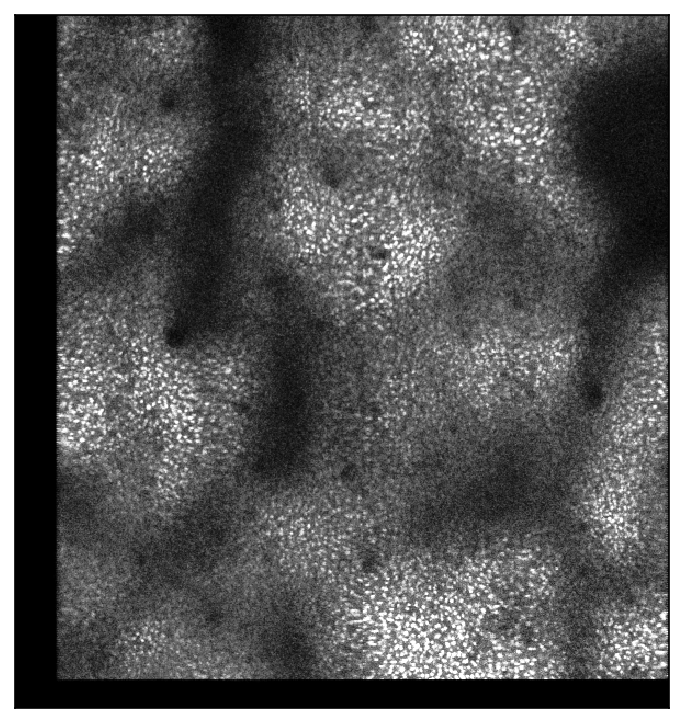

In [81]:
tfu.show_tif(im_full[0])

In [82]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (20, 3.33, 3.33)
job.params['npil_filt_xy_um'] = 60
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.80

params_to_sweep = {
    'cell_filt_xy_um' : (5,10),
    'npil_filt_xy_um' : (60, 100),
    'sdnorm_exp' : (0.8,0.9,1.0),
}
sweep = job.sweep_corrmap(params_to_sweep, iter_limit=2)

   Setting up sweep
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps with tag sweeps
      Updating self.dirs tag sweeps
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap with tag sweeps-corrmap
      Updating self.dirs tag sweeps-corrmap
   Total of 12 combinations
      Created directory for comb_00000 with params comb00000-params-cell_filt_xy_um_5.000-npil_filt_xy_um_60.000-sdnorm_exp_0.800
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap/comb_00000 with tag sweeps-corrmap-comb_00000
      Updating self.dirs tag sweeps-corrmap-comb_00000
      Created directory for comb_00001 with params comb00001-params-cell_filt_xy_um_5.000-npil_filt_xy_um_60.000-sdnorm_exp_0.900
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap/comb_00001 with tag sweeps-corrmap-comb_00001
      Updating self.dirs tag sweeps-corrmap-comb_00001
      Created directory for comb_00002 with params comb00002-params-cell_filt_

{'sweep_dir_path': '/mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap',
 'sweep_dir_name': 'sweeps-corrmap',
 'init_params': {'fs': 8.844286130709614,
  'tau': 1.3,
  'voxel_size_um': (20, 3.33, 3.33),
  'planes': array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24,  1,  3,  5,  7,
          9, 11, 13, 15]),
  'convert_plane_ids_to_channel_ids': False,
  'n_ch_tif': 26,
  'lbm': True,
  'notch_filt': None,
  'fix_fastZ': False,
  'num_colors': 1,
  'functional_color_channel': 0,
  'n_init_files': 4,
  'init_file_pool': None,
  'init_file_sample_method': 'even',
  'init_n_frames': None,
  'enforce_positivity': True,
  'fix_shallow_plane_shift_estimates': True,
  'fix_shallow_plane_shift_esimate_threshold': 20,
  'overwrite_plane_shifts': None,
  'subtract_crosstalk': True,
  'override_crosstalk': None,
  'crosstalk_percentile': 99.5,
  'crosstalk_sigma': 0.01,
  'cavity_size': 13,
  'crosstalk_n_planes': 2,
  'use_GPU_registration': True,
  'fuse_strips': True,
  'fuse_s

In [94]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (20, 3.33, 3.33)
job.params['npil_filt_xy_um'] = 80
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.8

params_to_sweep = {
    'cell_filt_type' : ('gaussian', 'unif'),
    'npil_filt_type' : ('gaussian', 'unif'),
    'cell_filt_xy_um' : (5, 15,),
    'npil_filt_xy_um' : (20, 80, 150),
    'sdnorm_exp' : (0.8, 1.0),
}
sweep = job.sweep_corrmap(params_to_sweep, iter_limit=4,sweep_name='corrmap4')

   Setting up sweep
      Found dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap4
      Updating self.dirs tag sweeps-corrmap4
   Total of 48 combinations
      Created directory for comb_00000 with params comb00000-params-cell_filt_type_gaussian-npil_filt_type_gaussian-cell_filt_xy_um_5.000-npil_filt_xy_um_20.000-sdnorm_exp_0.800
      Found dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap4/comb_00000
      Updating self.dirs tag sweeps-corrmap4-comb_00000
      Created directory for comb_00001 with params comb00001-params-cell_filt_type_gaussian-npil_filt_type_gaussian-cell_filt_xy_um_5.000-npil_filt_xy_um_20.000-sdnorm_exp_1.000
      Found dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/sweeps/corrmap4/comb_00001
      Updating self.dirs tag sweeps-corrmap4-comb_00001
      Created directory for comb_00002 with params comb00002-params-cell_filt_type_gaussian-npil_filt_type_gaussian-cell_filt_xy_um_5.000-npil_filt_xy_um_80.000-sdnorm_exp_0.800
      Fo

In [87]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (20, 3.33, 3.33)
job.params['npil_filt_xy_um'] = 60
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.90


In [88]:
%%time
corr_map = job.calculate_corr_map()

   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/corrmap with tag corrmap
      Updating self.dirs tag corrmap
   Created dir /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/mov_sub with tag mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-CR029_2024-08-26_1-2-3-4-5/corrmap
   Updated main params file
   Computing correlation map of movie with 29740 frames, volume shape: 21, 632, 596
      Running batch 1 of 149
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 2 of 149
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
      Running batch 3 of 149
         Loading movie into shared memory
         Subtracting neuropil and applying cell filters
         Reducing filtered movie to compute correlation map
 

In [89]:
res = job.load_corr_map_results()
vmap = res['vmap']

In [ ]:
# most important parameter - any value of the corrmap
# above this will be considered a peak for a possible ROI,
# and will be used as a "seed" to grow an ROI around it
# bigger number: fewer ROIs, only bright ones
# smaller number: many ROIs, increasingly worse quality
job.params['peak_thresh'] = 2.9

# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.5


job.segment_rois()

In [ ]:
# rois_dir_path = job.combine_patches(n.arange(80), job.dirs['rois'], deduplicate=False,
#                                     parent_dir_name='segmentation', info_use_idx=None)

In [ ]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])


In [ ]:

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'],iscell=iscell)

In [ ]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')